In [429]:
import numpy as np
from matplotlib import pyplot
from geojson.feature import *
import os
from tqdm import tqdm
import h3
import geopandas as gpd
import json
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import MiniBatchKMeans
import folium
from folium import Map, Marker, GeoJson
import branca.colormap as cm
from branca.colormap import LinearColormap
import vaex
import pandas as pd
from math import pi, cos, sin
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
from shapely.geometry import Polygon
from folium.features import Choropleth
from branca.colormap import linear
from sklearn.preprocessing import MinMaxScaler#
import calendar
from datetime import datetime

In [303]:
df = vaex.open('./data/trips_prepared.hdf5')

In [304]:
#engineer month and day out of datetime stemps
df['trip_start_timestamp'] = df['trip_start_timestamp'].astype('datetime64')
df['trip_end_timestamp'] = df['trip_end_timestamp'].astype('datetime64')

df['trip_start_month'] = df['trip_start_timestamp'].dt.month
df['trip_start_day'] = df['trip_start_timestamp'].dt.day

df['trip_end_month'] = df['trip_end_timestamp'].dt.month
df['trip_start_day'] = df['trip_start_timestamp'].dt.day

df.head()

#,trip_id,taxi_id,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_census_tract,dropoff_census_tract,pickup_community_area,dropoff_community_area,fare,tips,tolls,extras,trip_total,payment_type,company,pickup_centroid_latitude,pickup_centroid_longitude,dropoff_centroid_latitude,dropoff_centroid_longitude,trip_start_hour,trip_end_hour,trip_start_4h_period,trip_end_4h_period,trip_start_month,trip_start_day,trip_end_month
0,1b545d0be27b195076e5d2a7d4fc0ebef6ef20ac,'56a1119c6ca57e39525cf06829f9ecff553cf4b5ac24821...,2017-01-01 00:00:00.000000,2017-01-01 00:00:00.000000,240,1.3,1.70318e+10,1.70318e+10,32,28,6.25,0,0,0,6.25,Cash,Taxi Affiliation Services,41.881,-87.6327,41.8853,-87.6572,0,0,0,0,1,1,1
1,c3ee40051c5643c54064a8b9df3686d2d411518d,'7987cfe5e3b2c9869665f70fe35dbe7423e7fc5852f2d6f...,2017-01-01 00:00:00.000000,2017-01-01 00:15:00.000000,1500,0.4,1.70318e+10,1.70311e+10,32,8,22.75,4.85,0,1.5,29.1,Credit Card,Blue Ribbon Taxi Association Inc.,41.881,-87.6327,41.8983,-87.6208,0,0,0,0,1,1,1
2,29f30c8a6bbc028f5d63aa18c708d31b47267a9f,'0b269137bd94b55212311226d9e1554423e12bcc16a432c...,2017-01-01 00:00:00.000000,2017-01-01 00:30:00.000000,1620,0.9,1.70318e+10,1.70311e+10,32,8,12.25,2.85,0,2,17.1,Credit Card,Taxi Affiliation Services,41.881,-87.6327,41.8925,-87.6262,0,0,0,0,1,1,1
3,55ae4fa955e6bc8705b995248c34f4183d848c27,'d1d781b6807176ed53fbb9d0010dd0a87e29c073984bda6...,2017-01-01 00:00:00.000000,2017-01-01 00:00:00.000000,540,1,1.70311e+10,1.70311e+10,8,8,6.75,0,0,2,8.75,Cash,Dispatch Taxi Affiliation,41.9028,-87.6261,41.8909,-87.6189,0,0,0,0,1,1,1
4,ce908cd441e28d08dfb22bf168102beabb5e16e4,'f7630edc68a131c4a97382dd93206949da80ec1443d8da7...,2017-01-01 00:00:00.000000,2017-01-01 00:15:00.000000,480,0.5,1.70311e+10,1.70311e+10,8,8,6.25,2,0,1.5,9.75,Credit Card,Taxi Affiliation Services,41.8925,-87.6262,41.8909,-87.6189,0,0,0,0,1,1,1
5,fd25560e18dab95225999c264586a331dc3283f5,'9ff153898c75dbd960a207b660a71f92f79b666dcec98e1...,2017-01-01 00:00:00.000000,2017-01-01 00:30:00.000000,1980,3.4,1.70318e+10,1.70311e+10,32,8,16.75,3.65,0,1.5,21.9,Credit Card,Taxi Affiliation Services,41.881,-87.6327,41.895,-87.6197,0,0,0,0,1,1,1
6,2504e0bf058ff310ac4c197618a843f88fc1c0c6,'d3a5f1452b4a1db2a547e7a0aabfe28d67c62b0e40155fa...,2017-01-01 00:00:00.000000,2017-01-01 00:15:00.000000,960,5.9,1.70313e+10,1.70311e+10,32,6,17.5,0,0,1,18.5,Cash,Northwest Management LLC,41.8774,-87.622,41.9427,-87.6518,0,0,0,0,1,1,1
7,4ca1087133dfd8bde2483cb2aaa609fff2654f7c,'0083fcde0fb490b4ec424c63d1d750378f6ad11154d1d4a...,2017-01-01 00:00:00.000000,2017-01-01 00:15:00.000000,780,0.1,1.70312e+10,1.70311e+10,24,8,9.5,2.1,0,1,12.6,Credit Card,Taxi Affiliation Services,41.8997,-87.665,41.892,-87.6319,0,0,0,0,1,1,1
8,04bc3089a41c33afc9b6cbf5a9beac4fed91da7c,'785ef52cff80fe78a7ee899453036c0be6ac8fef4d10068...,2017-01-01 00:00:00.000000,2017-01-01 00:00:00.000000,120,0.4,1.70318e+10,1.70318e+10,32,32,4.25,2,0,1,7.25,Credit Card,Chicago Medallion Leasing INC,41.881,-87.6327,41.881,-87.6327,0,0,0,0,1,1,1
9,e09945909ae154d6b0ce433468baddcf79f79973,'b329626db30d23db0e6620de7d1a3036dd3c2ca3e139fd4...,2017-01-01 00:00:00.000000,2017-01-01 00:00:00.000000,180,0.7,1.70318e+10,1.70318e+10,32,28,5,0,0,2,7,Cash,Dispatch Taxi Affiliation,41.881,-87.6327,41.8853,-87.6572,0,0,0,0,1,1,1


In [305]:
df['trip_start_date'] = df['trip_start_timestamp'].dt.date

# 2. Demand Patterns
We start by generally plotting the changes of demand on a daily basis.
This will lay the foundation for further analysis, meaning checking the possible connection between demand and temperature, results of changes in demand and revenue and tips, as well as checking the impact of holidays on the demand.
Vielleicht noch hourly demand nach week oder month im zusammenhang mit Temperatur zusammenbringen oder so

## 2.1 General Demand

In [338]:
trip_counts_date = df.groupby(by='trip_start_date').agg({'count': vaex.agg.count('trip_id')}) 

In [339]:
trip_counts_date = trip_counts_date.sort('trip_start_date')
trip_counts_date.head()

#,trip_start_date,count
0,2017-01-01,19944
1,2017-01-02,9697
2,2017-01-03,19541
3,2017-01-04,25692
4,2017-01-05,32098
5,2017-01-06,35194
6,2017-01-07,21405
7,2017-01-08,15474
8,2017-01-09,25860
9,2017-01-10,32128


In [340]:
trip_counts_date = trip_counts_date.to_pandas_df()

In [341]:
trip_counts_date['trip_start_date'] = pd.to_datetime(trip_counts_date['trip_start_date'])

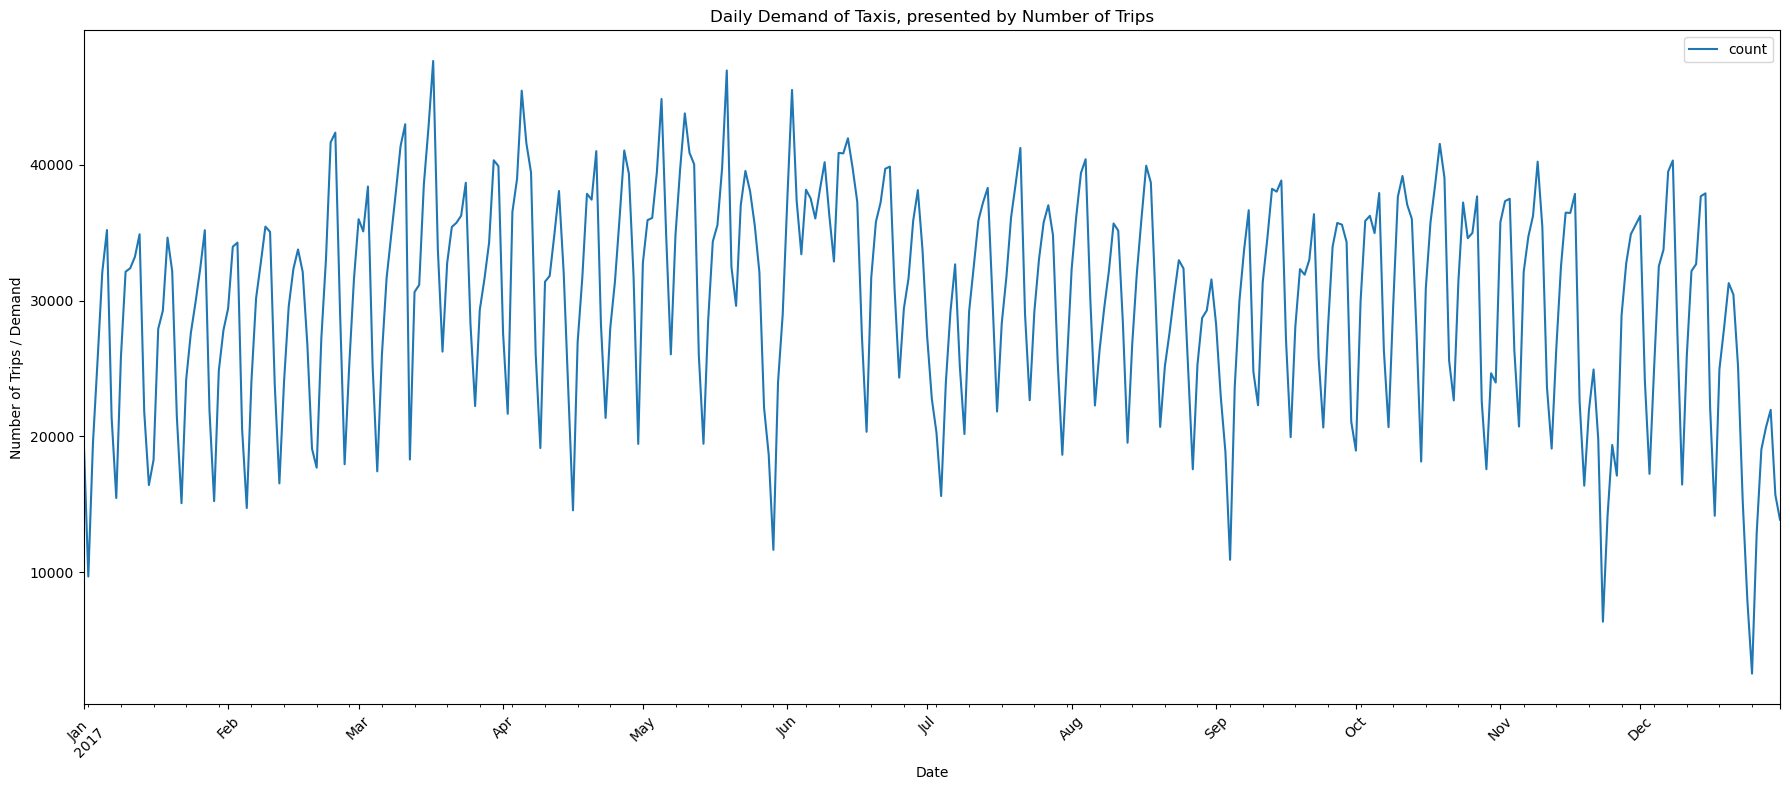

In [834]:
trip_counts_date.plot(x='trip_start_date', y='count', kind='line', figsize=(18,8)) 
plt.xlabel('Date')
plt.ylabel('Number of Trips / Demand')
plt.title('Daily Demand of Taxis, presented by Number of Trips')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 2.1.1 Impact of Temperature on Demand

In [504]:
weather_df = pd.read_csv('./data/weather_data_final.csv')

In [505]:
#Drop unuseful columns
weather_df.drop(['humidity', 'dew_point', 'wind_speed', 'wind_gust', 'pressure'], axis =1, inplace = True)

In [506]:
#calculate average temps and precips for the date
weather_daily = weather_df[['date', 'temp', 'precip', 'date_time', 'condition']]

In [507]:
weather_daily = weather_daily.copy()
weather_daily['temp'] = weather_daily.loc[:, 'temp'].astype(str)
weather_daily.loc[:,'temp'] = weather_daily['temp'].astype(str).str.strip(' °F').astype(float)

In [508]:
weather_daily = weather_daily.groupby(['date'])['temp'].mean()
weather_daily = weather_daily.reset_index()

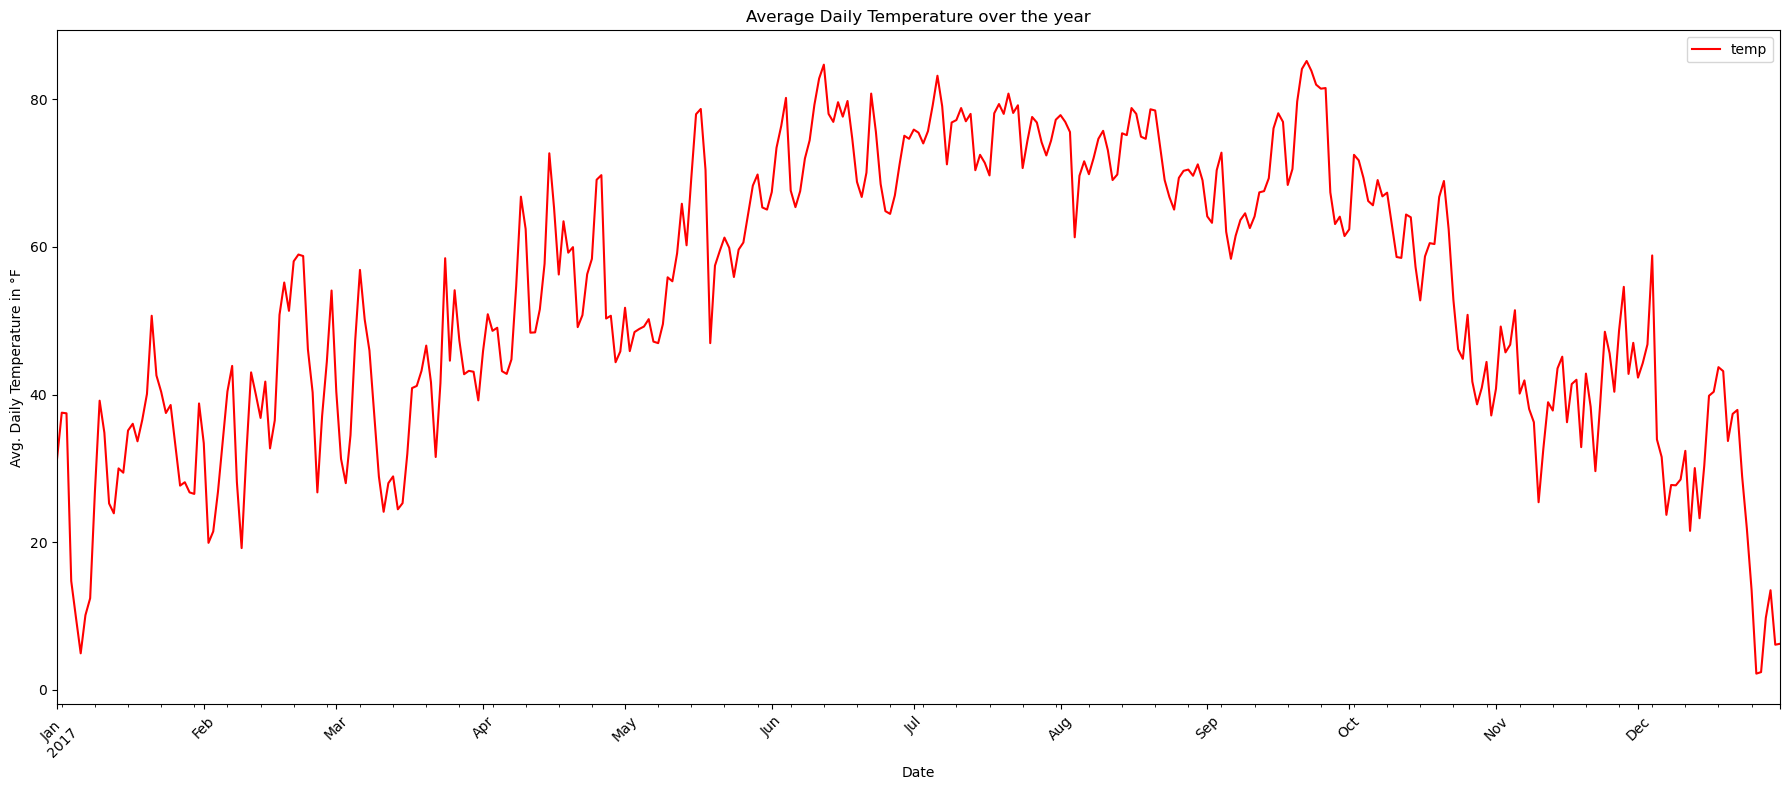

In [833]:
weather_daily.plot(x='date', y='temp', kind='line', color ='red', figsize=(18,8)) 
plt.xlabel('Date')
plt.ylabel('Avg. Daily Temperature in °F')
plt.title('Average Daily Temperature over the year')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [500]:
weather_daily['date'] = pd.to_datetime(weather_daily['date'])
trip_counts_date['trip_start_date'] = pd.to_datetime(trip_counts_date['trip_start_date'])

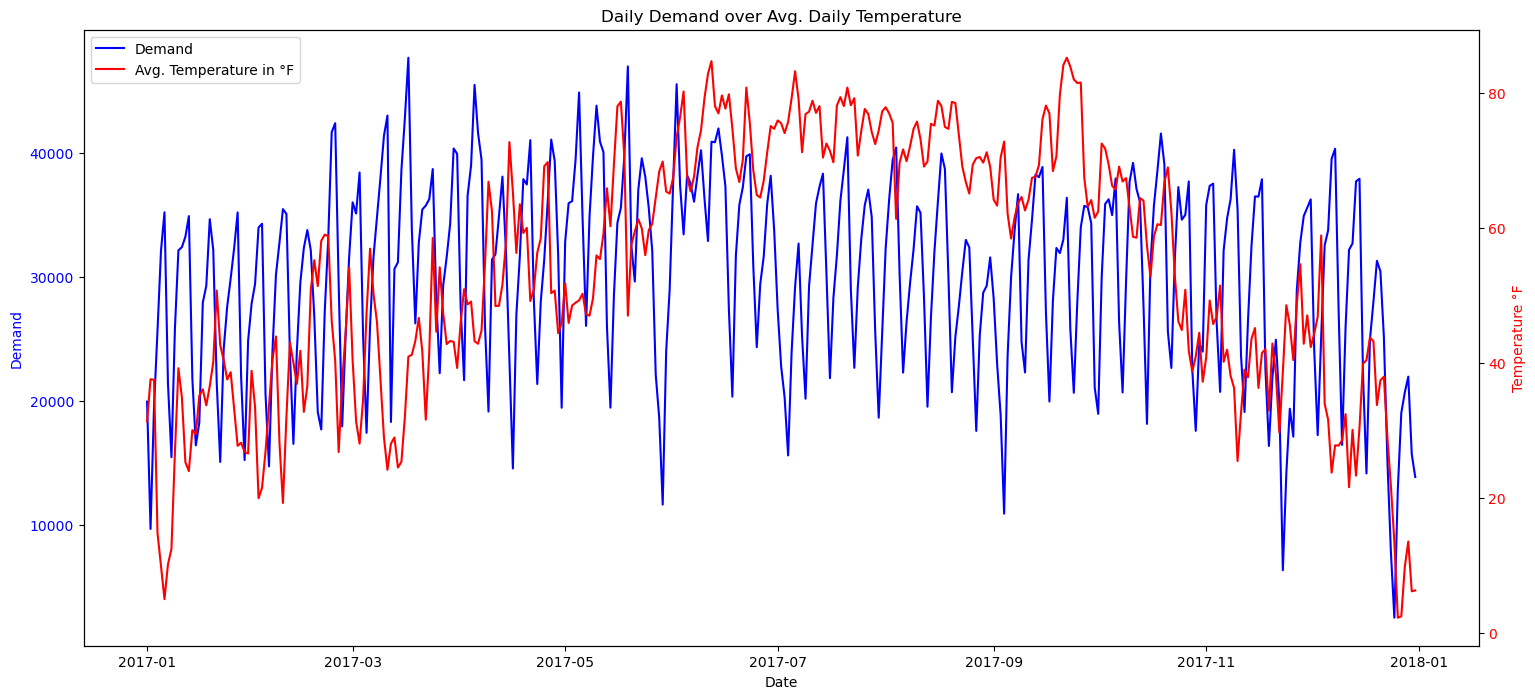

In [1088]:
fig, ax1 = plt.subplots(figsize=(18, 8))

# Plotting demand on the primary y-axis (green color)
ax1.plot(trip_counts_date['trip_start_date'], trip_counts_date['count'], color='b', label='Demand')
ax1.set_xlabel("Date")
ax1.set_ylabel("Demand", color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Create a twin axis for the secondary y-axis
ax2 = ax1.twinx()

# Plotting temperature on the secondary y-axis (red color)
ax2.plot(weather_daily['date'], weather_daily['temp'], color='r', label='Avg. Temperature in °F')
ax2.set_ylabel("Temperature °F", color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Naming the whole graph
plt.title("Daily Demand over Avg. Daily Temperature")

# Adding legend, which helps us recognize the curve according to its color
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

# To load the display window
plt.show()

In [876]:
correlation = weather_daily['temp'].corr(trip_counts_date['count'])
print(f"Correlation between temperature and demand: {correlation:.2f}")

Correlation between temperature and demand: 0.18


## 2.1.2 Impact of weather conditions on Demand

In [542]:
conditions_daily = weather_df[['date','condition']]

In [543]:
#First create a mapping of all possibel weather conditions to numerical values
#[Fair, Mostly Cloudy, Partly Cloudy, Cloudy, Light Rain, Thunder] => [0,1,2,3,4,5]
conditions_daily = conditions_daily.copy()
conditions_map = {
    "Fair": 0,
    "Mostly Cloudy": 1,
    "Partly Cloudy": 2,
    "Cloudy": 3,
    "Light Rain": 4,
    "Thunder": 5
}

conditions_daily['condition_map'] = conditions_daily['condition'].map(conditions_map)
conditions_daily['condition_map'] = conditions_daily['condition_map'].astype(float)
conditions_daily['date'] = pd.to_datetime(conditions_daily['date'])

In [823]:
#Calculating average weather condition of each day
#conditions_daily = conditions_daily.groupby(['date'])['condition_map'].mean()

#round mean of result to maintain the clear categorization of weather conditions
conditions_daily = round(conditions_daily.groupby(['date'])['condition_map'].mean(),0) 
conditions_daily = conditions_daily.reset_index()

In [824]:
conditions_daily.head()

,date,condition_map
0,2017-01-01,1.0
1,2017-01-02,2.0
2,2017-01-03,3.0
3,2017-01-04,1.0
4,2017-01-05,1.0


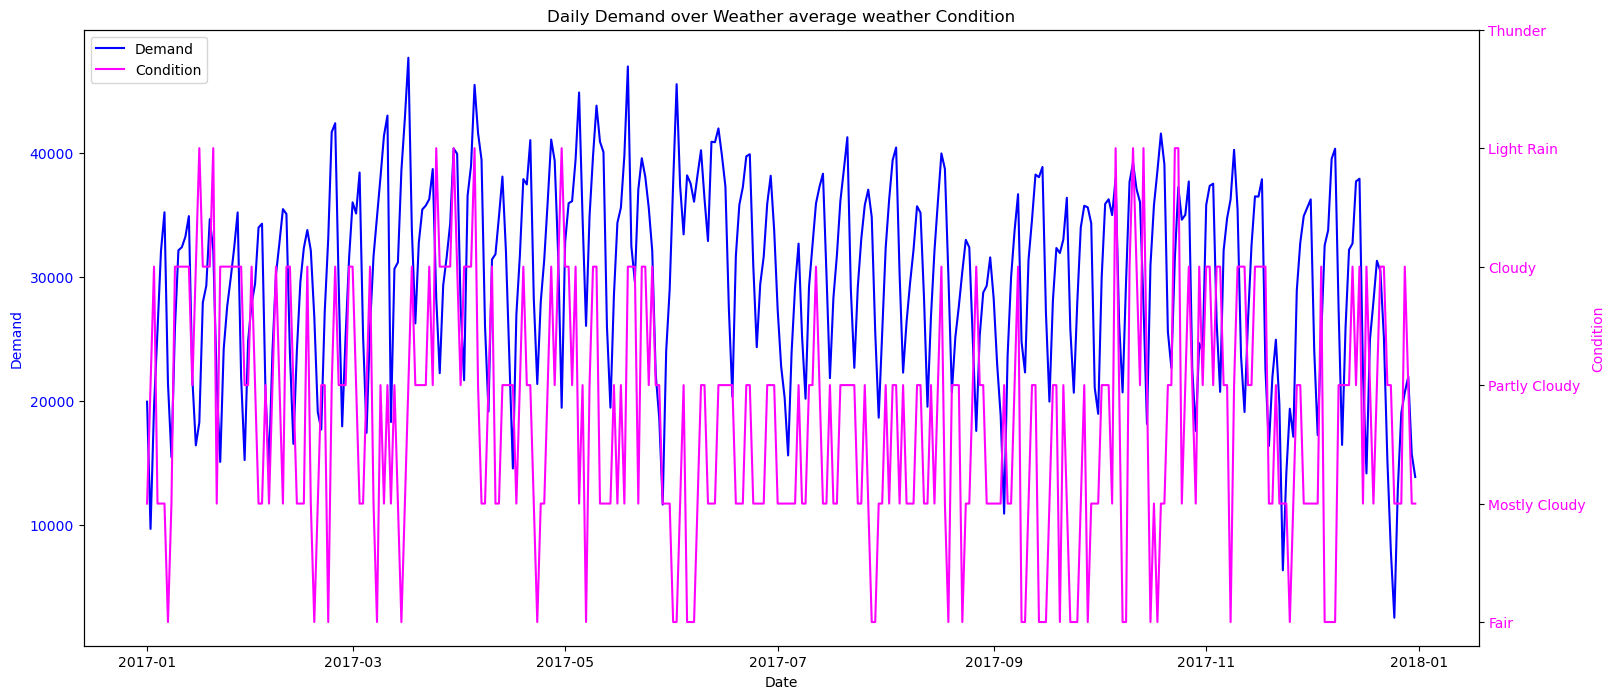

In [827]:
cond_arr = ['Fair', 'Mostly Cloudy', 'Partly Cloudy', 'Cloudy', 'Light Rain', 'Thunder']
fig, ax1 = plt.subplots(figsize=(18, 8))

# Plotting demand on the primary y-axis (green color)
ax1.plot(trip_counts_date['trip_start_date'], trip_counts_date['count'], color='b', label='Demand')
ax1.set_xlabel("Date")
ax1.set_ylabel("Demand", color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Create a twin axis for the secondary y-axis
ax2 = ax1.twinx()

# Plotting temperature on the secondary y-axis (red color)
ax2.plot(conditions_daily['date'], conditions_daily['condition_map'], color='magenta', label='Condition')
ax2.set_ylabel("Condition", color='magenta')
ax2.tick_params(axis='y', labelcolor='magenta')
ax2.set_yticks(range(len(cond_arr)))
ax2.set_yticklabels(cond_arr)

# Naming the whole graph
plt.title('Daily Demand over Weather average weather Condition')

# Adding legend, which helps us recognize the curve according to its color
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

# To load the display window
plt.show()

In [826]:
merged_data = pd.merge(conditions_daily, trip_counts_date, left_on='date', right_on='trip_start_date', how='inner')
correlation = merged_data['condition_map'].corr(merged_data['count'])
print(f"Correlation between average weather condition and demand: {correlation:.2f}")

Correlation between average weather condition and demand: 0.09


## 2.1.3 Impact of precipication on demand

In [420]:
precip_daily = weather_df[['date', 'precip', 'date_time']]

In [421]:
precip_daily = precip_daily.copy()
precip_daily['precip'] = precip_daily['precip'].astype(str).str.strip(' °in').astype(float)
precip_daily['date'] = pd.to_datetime(precip_daily['date'])

In [422]:
precip_daily = precip_daily.groupby(['date'])['precip'].mean()
precip_daily = precip_daily.reset_index()

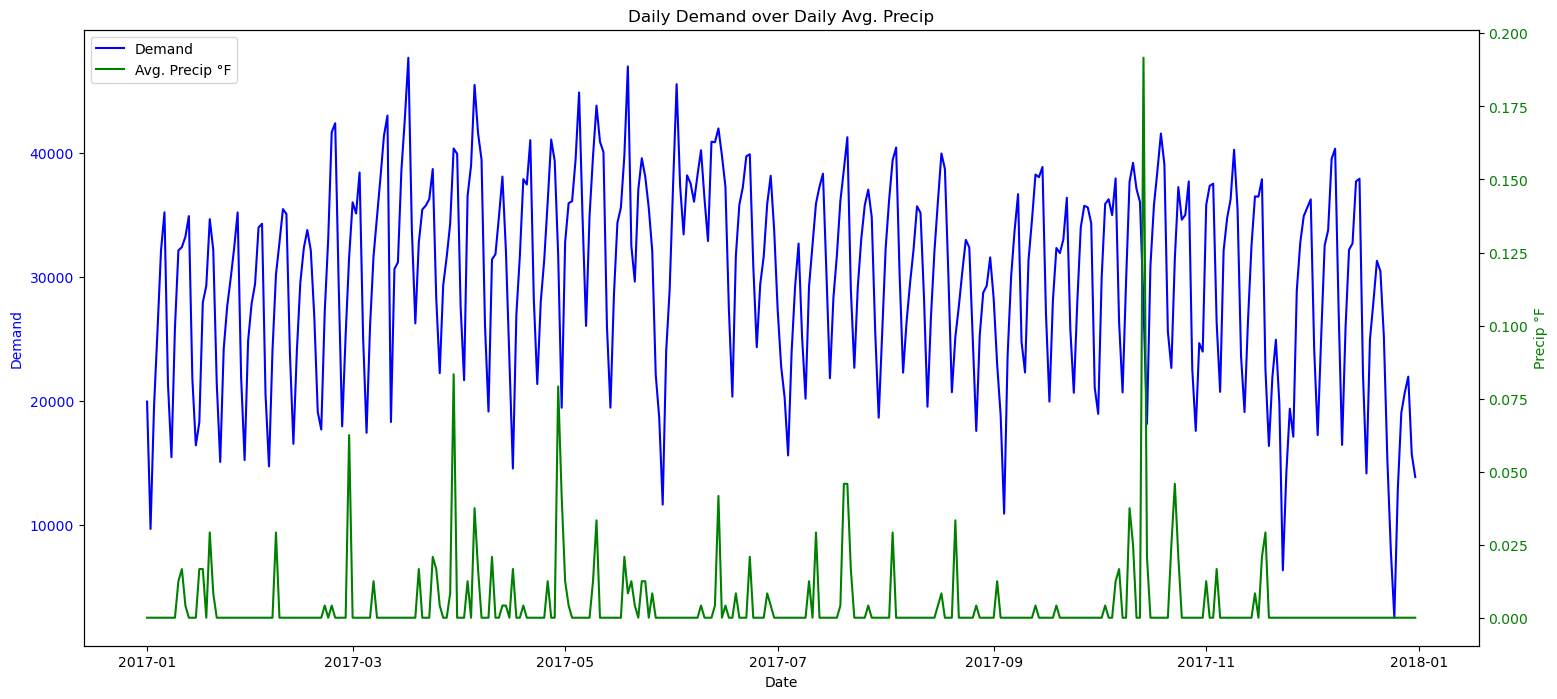

In [832]:
fig, ax1 = plt.subplots(figsize=(18, 8))

# Plotting demand on the primary y-axis (green color)
ax1.plot(trip_counts_date['trip_start_date'], trip_counts_date['count'], color='b', label='Demand')
ax1.set_xlabel("Date")
ax1.set_ylabel("Demand", color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Create a twin axis for the secondary y-axis
ax2 = ax1.twinx()

# Plotting temperature on the secondary y-axis (red color)
ax2.plot(trip_counts_date['trip_start_date'], precip_daily['precip'], color='g', label='Avg. Precip °F')
ax2.set_ylabel("Precip °F", color='g')
ax2.tick_params(axis='y', labelcolor='g')

# Naming the whole graph
plt.title("Daily Demand over Daily Avg. Precip")

# Adding legend, which helps us recognize the curve according to its color
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

# To load the display window
plt.show()

In [424]:
merged_data = pd.merge(precip_daily, trip_counts_date, left_on='date', right_on='trip_start_date', how='inner')
correlation = merged_data['precip'].corr(merged_data['count'])
print(f"Correlation between temperature and demand: {correlation:.2f}")

Correlation between temperature and demand: 0.12


## 2.1.4 Impact of Holidays on Demand

In [ ]:
#All holidays and non-working days in chicago in 2017:
# 01.01, 02.01, 16.01, 20.01, 20.02, 29.05, 04.07, 04.09, 09.10, 10.11, 11.11, 23.11, 25.11
#Source: https://www.timeanddate.com/holidays/us/2017?hol=9

In [432]:
holiday_strings = [
    "01.01.2017", "02.01.2017", "16.01.2017", "20.01.2017", "20.02.2017", "29.05.2017",
    "04.07.2017", "04.09.2017", "09.10.2017", "10.11.2017", "11.11.2017", "23.11.2017", "25.11.2017"
]

date_format = "%d.%m.%Y"

holidays = [datetime.strptime(date, date_format) for date in holiday_strings]
print(holidays)

[datetime.datetime(2017, 1, 1, 0, 0), datetime.datetime(2017, 1, 2, 0, 0), datetime.datetime(2017, 1, 16, 0, 0), datetime.datetime(2017, 1, 20, 0, 0), datetime.datetime(2017, 2, 20, 0, 0), datetime.datetime(2017, 5, 29, 0, 0), datetime.datetime(2017, 7, 4, 0, 0), datetime.datetime(2017, 9, 4, 0, 0), datetime.datetime(2017, 10, 9, 0, 0), datetime.datetime(2017, 11, 10, 0, 0), datetime.datetime(2017, 11, 11, 0, 0), datetime.datetime(2017, 11, 23, 0, 0), datetime.datetime(2017, 11, 25, 0, 0)]


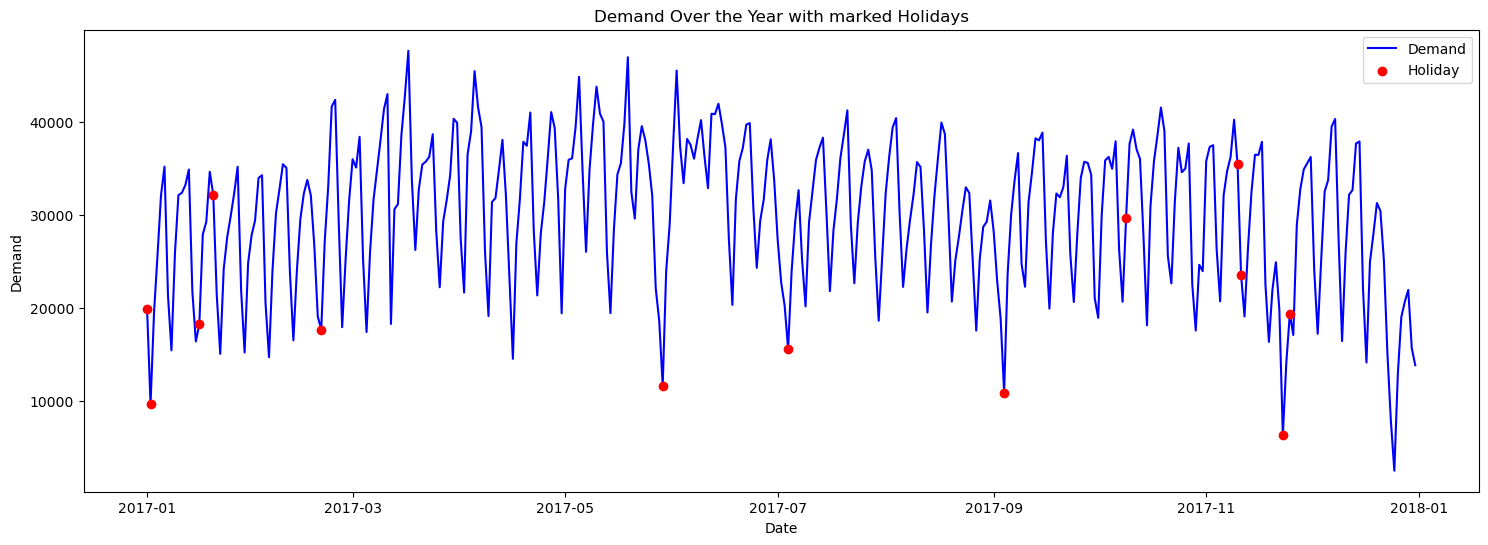

In [835]:
plt.figure(figsize=(18, 6))
plt.plot(trip_counts_date['trip_start_date'], trip_counts_date['count'], linestyle='-', color='blue', label='Demand')

legend = True
for holiday in holidays:
    label = 'Holiday' if legend else None
    plt.scatter(holiday, trip_counts_date[trip_counts_date['trip_start_date'] == holiday]['count'], color='red', zorder=5, label=label)
    legend = False
    
plt.xlabel("Date")
plt.ylabel("Demand")
plt.title("Demand Over the Year with marked Holidays")
plt.legend()

plt.show()

In [448]:
#create isHoliday attribute to check for correlation later
def isHoliday(date):
    return date in holidays

trip_counts_date['isHoliday'] = trip_counts_date['trip_start_date'].apply(isHoliday)

In [487]:
correlation = trip_counts_date['isHoliday'].corr(trip_counts_date['count'])
print(f"Correlation between Holidays and demand: {correlation:.2f}")

Correlation between Holidays and demand: -0.26


In [452]:
#Calculating average demand on holidays and non-holidays
avg = trip_counts_date.groupby('isHoliday')['count'].mean()
print(avg)

isHoliday
False    30483.803977
True     19262.384615
Name: count, dtype: float64


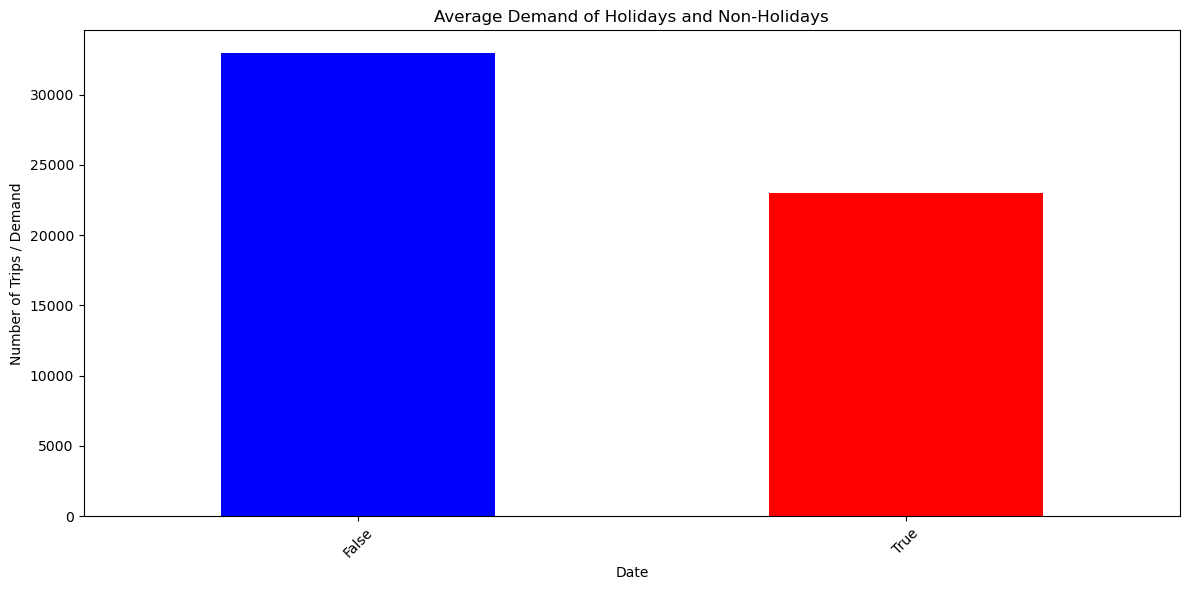

In [474]:
avg.plot(x='isHoliday', y='count', kind='bar', figsize=(12,6), color = ['blue','red']) 
plt.xlabel('Date')
plt.ylabel('Number of Trips / Demand')
plt.title('Average Demand of Holidays and Non-Holidays')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 2.1.5 Impact of Weekends on Demand


In [465]:
trip_counts_date['isWeekend'] = trip_counts_date['trip_start_date'].dt.dayofweek >= 5

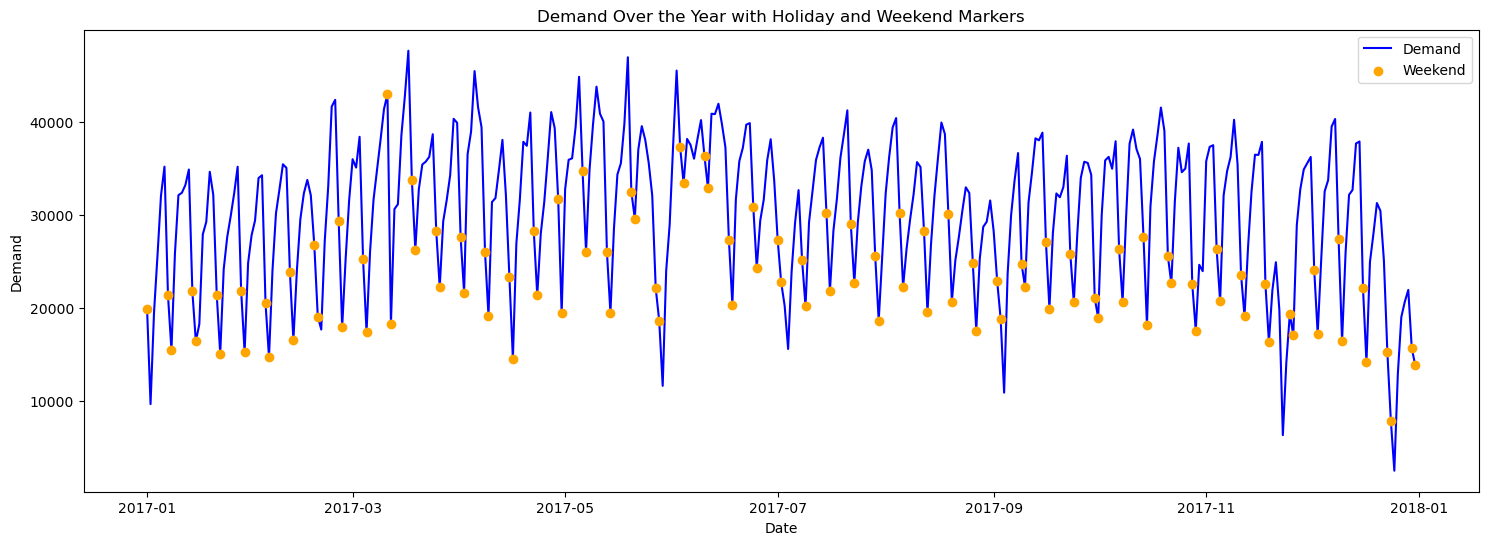

In [836]:
plt.figure(figsize=(18, 6))
plt.plot(trip_counts_date['trip_start_date'], trip_counts_date['count'], linestyle='-', color='blue', label='Demand')

legend = True
for index, row in trip_counts_date.iterrows():
    if row['isWeekend']:
        label = 'Weekend' if legend else None
        plt.scatter(row['trip_start_date'], row['count'], color='orange', zorder=5, label=label)
        legend = False
plt.xlabel("Date")
plt.ylabel("Demand")
plt.title("Demand Over the Year with Holiday and Weekend Markers")
plt.legend()

plt.show()

In [649]:
avg = trip_counts_date.groupby('isWeekend')['count'].mean()
avg = avg.reset_index()
print(avg)

   isWeekend         count
0      False  32934.553846
1       True  23025.961905


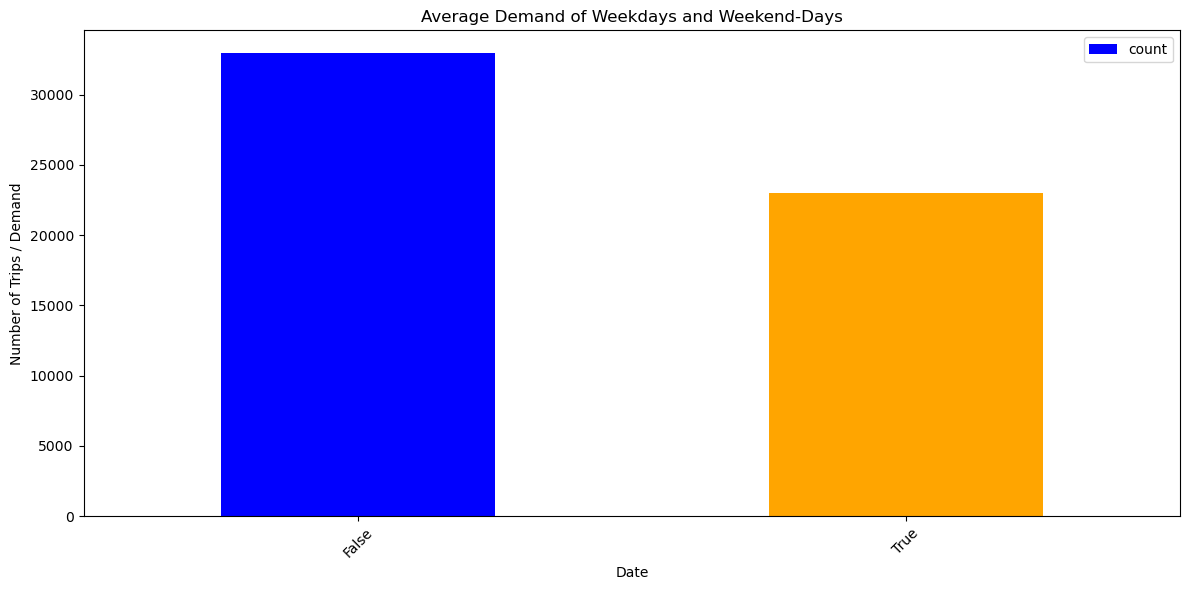

In [644]:
avg.plot(x='isWeekend', y='count', kind='bar', figsize=(12,6), color = ['blue','orange']) 
plt.xlabel('Date')
plt.ylabel('Number of Trips / Demand')
plt.title('Average Demand of Weekdays and Weekend-Days')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [486]:
correlation = trip_counts_date['isWeekend'].corr(trip_counts_date['count'])
print(f"Correlation between Holidays and demand: {correlation:.2f}")

Correlation between Holidays and demand: -0.57


## 2.2 Demand Patterns of individual Weekdays

Logically this representation is only partially expressive, as there are two weekend days which appear to determine differnt demand patterns. Thus in the next section we'll look further in the demand for alle weekdays

## 2.2.1 Weekdays on Demand Curve

In [478]:
#Create Weekday column in trip_counts_date dataframe
# 0 = Monday -> 6 = Sunday
trip_counts_date['weekday'] = trip_counts_date['trip_start_date'].dt.dayofweek

In [479]:
trip_counts_date.head()

,trip_start_date,count,isHoliday,isWeekend,weekday
0,2017-01-01,19944,True,True,6
1,2017-01-02,9697,True,False,0
2,2017-01-03,19541,False,False,1
3,2017-01-04,25692,False,False,2
4,2017-01-05,32098,False,False,3


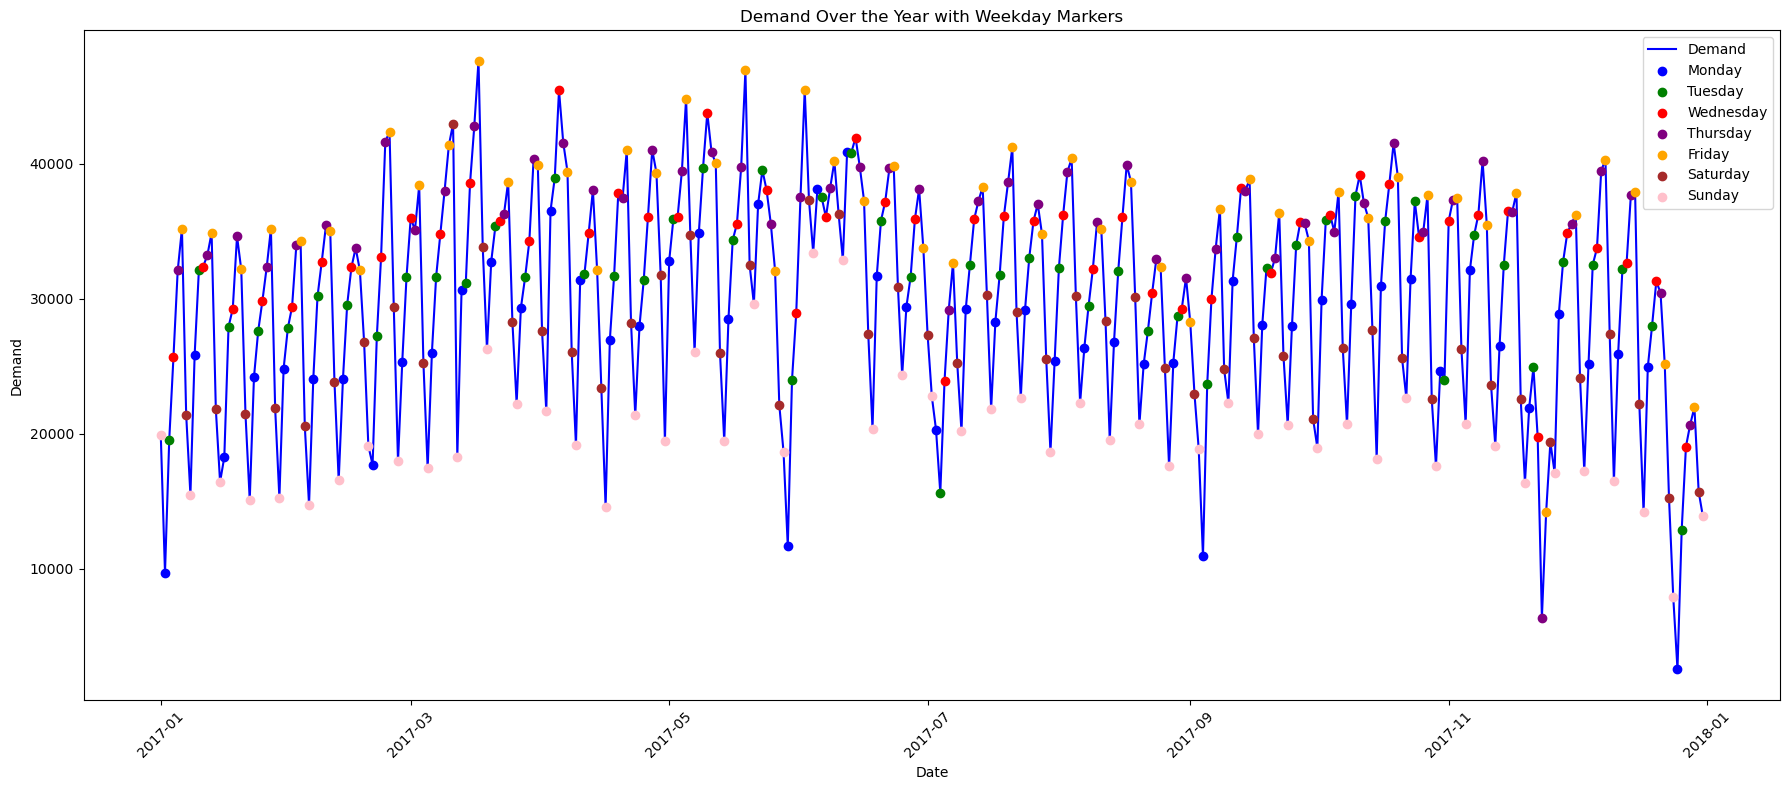

In [837]:
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown', 'pink']

plt.figure(figsize=(18, 8))
plt.plot(trip_counts_date['trip_start_date'], trip_counts_date['count'], linestyle='-', color='blue', label='Demand')

for weekday in range(7):
    weekday_data = trip_counts_date[trip_counts_date['weekday'] == weekday]
    plt.scatter(weekday_data['trip_start_date'], weekday_data['count'], color=colors[weekday], zorder=5, label=weekdays[weekday])

plt.xlabel("Date")
plt.ylabel("Demand")
plt.title("Demand Over the Year with Weekday Markers")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [489]:
correlation = trip_counts_date['weekday'].corr(trip_counts_date['count'])
print(f"Correlation between the Weekday and demand: {correlation:.2f}")

Correlation between the Weekday and demand: -0.26


## 2.2.2 General Demand Proportion of Weekdays

In [573]:
# Proportion of Demand of each weekday (in total)
trip_counts_weekday = trip_counts_date.groupby('weekday')['count'].sum()
trip_counts_weekday = trip_counts_weekday.reset_index()
total_demand = trip_counts_date['count'].sum()

In [574]:
print(total_demand)

10980710


In [608]:
weekday_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
trip_counts_weekday['weekday_name'] = trip_counts_weekday['weekday'].map(lambda x: weekday_names[x])
trip_counts_weekday['proportion'] = trip_counts_weekday['count'].apply(lambda x: x/total_demand)

In [609]:
trip_counts_weekday.head(20)

,weekday,count,proportion,weekday_name
0,0,1389446,0.126535,Monday
1,1,1625172,0.148002,Tuesday
2,2,1772157,0.161388,Wednesday
3,3,1871436,0.170429,Thursday
4,4,1904773,0.173465,Friday
5,5,1372954,0.125033,Saturday
6,6,1044772,0.095146,Sunday


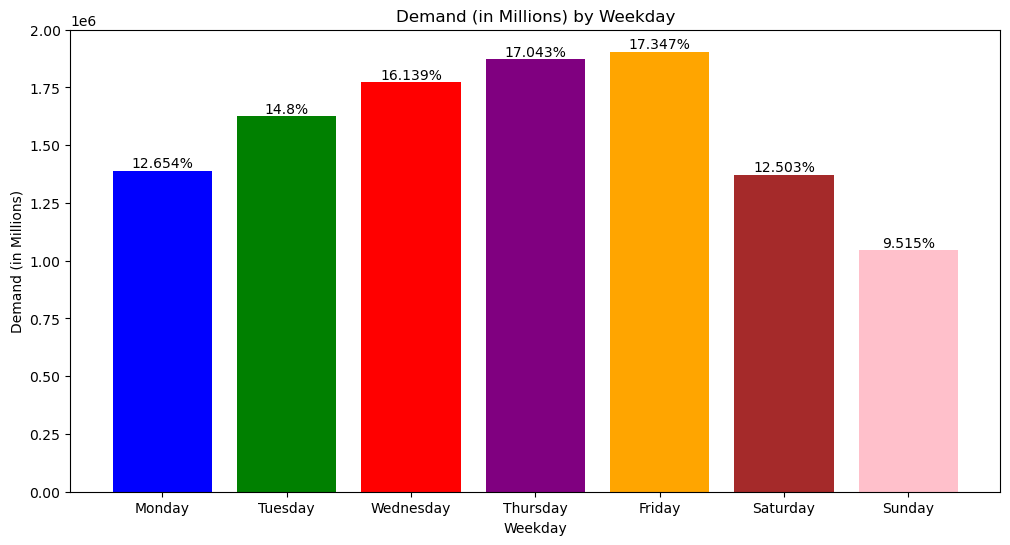

In [822]:
plt.figure(figsize=(12, 6))
bars = plt.bar(trip_counts_weekday['weekday_name'], trip_counts_weekday['count'], color=colors)
for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
             f"{round(bar.get_height() / total_demand * 100, 3)}%", ha='center', va='bottom', fontsize=10, color='black')

plt.xlabel('Weekday')
plt.ylabel('Demand (in Millions)')
plt.title('Demand (in Millions) by Weekday')
plt.show()

## 2.2.3 Seasonal Demand proportion of Weekdays

In [669]:
#Starting off, by Mapping the Months to the season
seasons_map = {1: 'Winter', 2: 'Winter', 3: 'Spring', 4: 'Spring', 5: 'Spring',6: 'Summer', 7: 'Summer', 8: 'Summer', 9: 'Fall', 10: 'Fall', 11: 'Fall', 12: 'Winter'}
trip_counts_date['season'] = trip_counts_date['trip_start_date'].dt.month.map(seasons_map)

#Customizing weekday-name mapping so it loops over whole dataset and not only one instance of weekday each, as previously done due to aggregation on weekday
weekday_names = {0: 'Monday',1: 'Tuesday',2: 'Wednesday',3: 'Thursday',4: 'Friday',5: 'Saturday',6: 'Sunday'}
trip_counts_date['weekday_name'] = trip_counts_date['weekday'].apply(lambda x: weekday_names[x])

In [671]:
trip_counts_date.head()

,trip_start_date,count,isHoliday,isWeekend,weekday,season,weekday_name
0,2017-01-01,19944,True,True,6,Winter,Sunday
1,2017-01-02,9697,True,False,0,Winter,Monday
2,2017-01-03,19541,False,False,1,Winter,Tuesday
3,2017-01-04,25692,False,False,2,Winter,Wednesday
4,2017-01-05,32098,False,False,3,Winter,Thursday


In [678]:
#Calculating the general demand of every season
season_demand = trip_counts_date.groupby(['season'])['count'].sum().reset_index()

In [679]:
season_demand.head(10)

,season,count
0,Fall,2685515
1,Spring,3024549
2,Summer,2917183
3,Winter,2353463


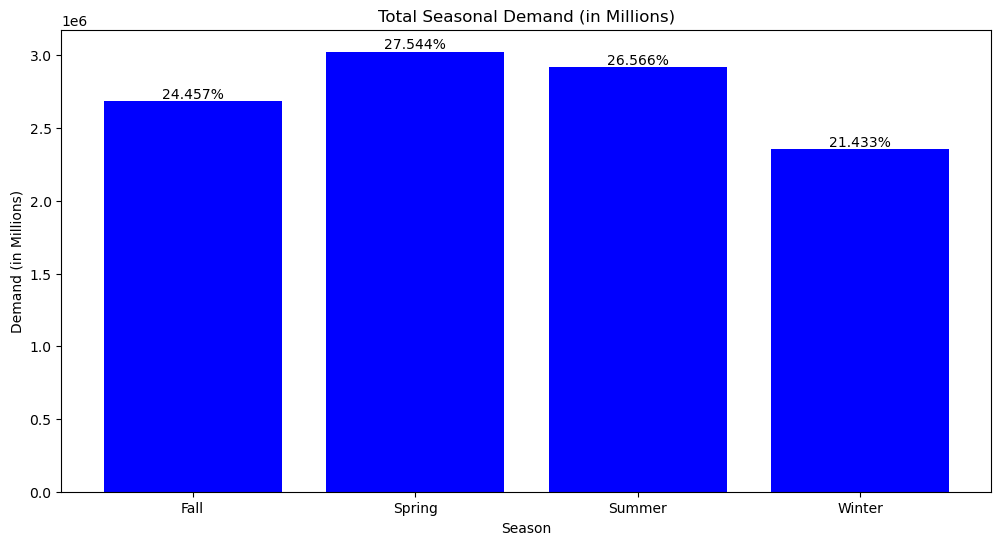

In [790]:
plt.figure(figsize=(12, 6))
bars = plt.bar(season_demand['season'], season_demand['count'], color='blue')
for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
             f"{round(bar.get_height() / total_demand * 100, 3)}%", ha='center', va='bottom', fontsize=10, color='black')

plt.xlabel('Season')
plt.ylabel('Demand (in Millions)')
plt.title('Total Seasonal Demand (in Millions)')
plt.show()

In [760]:
#ToDo: Correlation

In [771]:
#Calculating the demand for every weekday for all seasons
season_weekday_demand = trip_counts_date.groupby(['season', 'weekday_name'])['count'].sum().reset_index()

In [772]:
season_weekday_demand.head()

,season,weekday_name,count
0,Fall,Friday,450048
1,Fall,Monday,354376
2,Fall,Saturday,315674
3,Fall,Sunday,253162
4,Fall,Thursday,444818


In [773]:
#Sorting dataframe from Monday to Sunday in order to maintain uniform color code of weekdays
custom_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Convert 'weekday_name' column to categorical to enable sorting with custom order
season_weekday_demand['weekday_name'] = pd.Categorical(season_weekday_demand['weekday_name'], categories=custom_order, ordered=True)
season_weekday_demand.sort_values(by=['season', 'weekday_name'])

,season,weekday_name,count
1,Fall,Monday,354376
5,Fall,Tuesday,419888
6,Fall,Wednesday,447549
4,Fall,Thursday,444818
0,Fall,Friday,450048
2,Fall,Saturday,315674
3,Fall,Sunday,253162
8,Spring,Monday,386401
12,Spring,Tuesday,437194
13,Spring,Wednesday,516071


In [777]:
pivot_season = season_weekday_demand.pivot(index='season', columns='weekday_name', values='count')

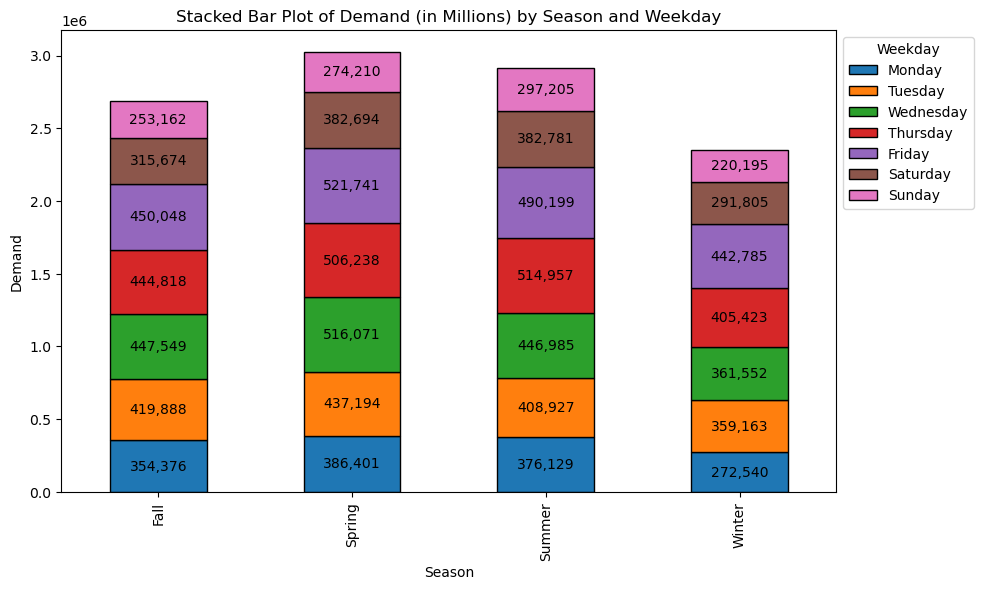

In [788]:
ax = pivot_season.plot(kind='bar', stacked=True, figsize=(10, 6))
for container in ax.containers:
    plt.setp(container, edgecolor='black')
    for rect in container.patches:
        width = rect.get_width()
        height = rect.get_height()
        x = rect.get_x()
        y = rect.get_y()
        ax.text(x + width / 2, y + height / 2, f'{int(height):,}', ha='center', va='center', color='black')

plt.xlabel('Season')
plt.ylabel('Demand')
plt.title('Stacked Bar Plot of Demand (in Millions) by Season and Weekday')
plt.legend(title='Weekday', bbox_to_anchor=(1, 1))

plt.show()

## 2.2.4 Monthly Demand proportion of Weekdays

In [747]:
trip_counts_date['month'] = trip_counts_date['trip_start_date'].dt.month

In [748]:
trip_counts_date.head()

,trip_start_date,count,isHoliday,isWeekend,weekday,season,weekday_name,month,month_name
0,2017-01-01,19944,True,True,6,Winter,Sunday,1,January
1,2017-01-02,9697,True,False,0,Winter,Monday,1,January
2,2017-01-03,19541,False,False,1,Winter,Tuesday,1,January
3,2017-01-04,25692,False,False,2,Winter,Wednesday,1,January
4,2017-01-05,32098,False,False,3,Winter,Thursday,1,January


In [749]:
month_demand = trip_counts_date.groupby(['month'])['count'].sum().reset_index()

In [754]:
months_map = {1: 'January', 2: 'February', 3: 'March', 4: 'April', 5: 'May',6: 'June', 7: 'July', 8: 'August', 9: 'September', 10: 'October', 11: 'November', 12: 'December'}
month_demand['month_name'] = month_demand['month'].map(months_map)

In [755]:
month_demand.head(12)

,month,count,month_name
0,1,793557,January
1,2,794775,February
2,3,1040894,March
3,4,954142,April
4,5,1029513,May
5,6,1069766,June
6,7,909640,July
7,8,937777,August
8,9,876873,September
9,10,965070,October


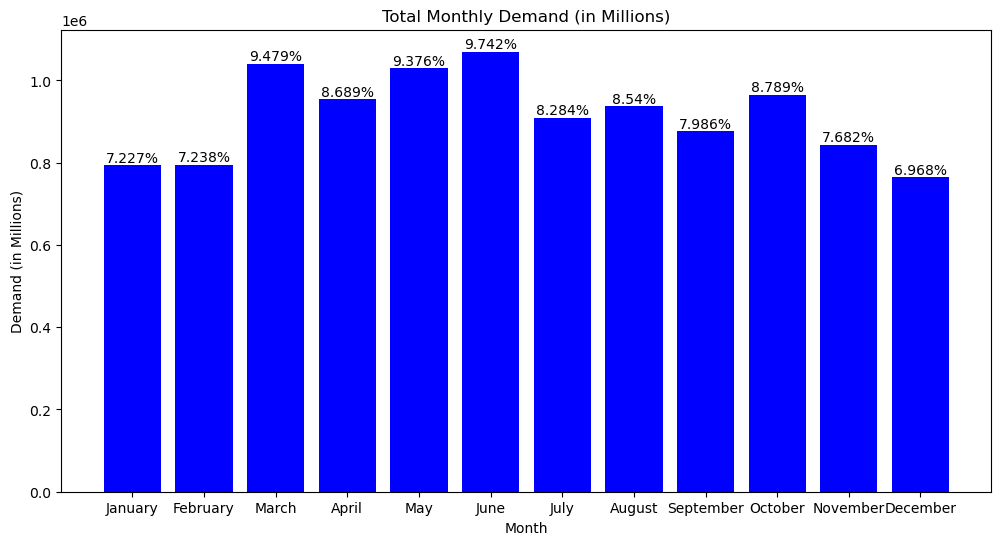

In [789]:
plt.figure(figsize=(12, 6))
bars = plt.bar(month_demand['month_name'], month_demand['count'], color='blue')
for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
             f"{round(bar.get_height() / total_demand * 100, 3)}%", ha='center', va='bottom', fontsize=10, color='black')

plt.xlabel('Month')
plt.ylabel('Demand (in Millions)')
plt.title('Total Monthly Demand (in Millions)')
plt.show()

In [844]:
correlation = trip_counts_date['month'].corr(trip_counts_date['count'])
print(f"Correlation between the Month and Demand: {correlation:.2f}")

Correlation between the Month and Demand: -0.09


In [766]:
month_weekday_demand = trip_counts_date.groupby(['month_name', 'weekday_name'])['count'].sum().reset_index()
#Again sorting after custom order
custom_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Convert 'weekday_name' column to categorical to enable sorting with custom order
month_weekday_demand['weekday_name'] = pd.Categorical(month_weekday_demand['weekday_name'], categories=custom_order, ordered=True)
month_weekday_demand.sort_values(by=['month_name', 'weekday_name'])

,month_name,weekday_name,count
1,April,Monday,122852
5,April,Tuesday,133842
6,April,Wednesday,154247
4,April,Thursday,158126
0,April,Friday,151861
...,...,...,...
83,September,Wednesday,135832
81,September,Thursday,140334
77,September,Friday,174425
79,September,Saturday,121661


In [780]:
pivot_month = month_weekday_demand.pivot(index='month_name', columns='weekday_name', values='count')

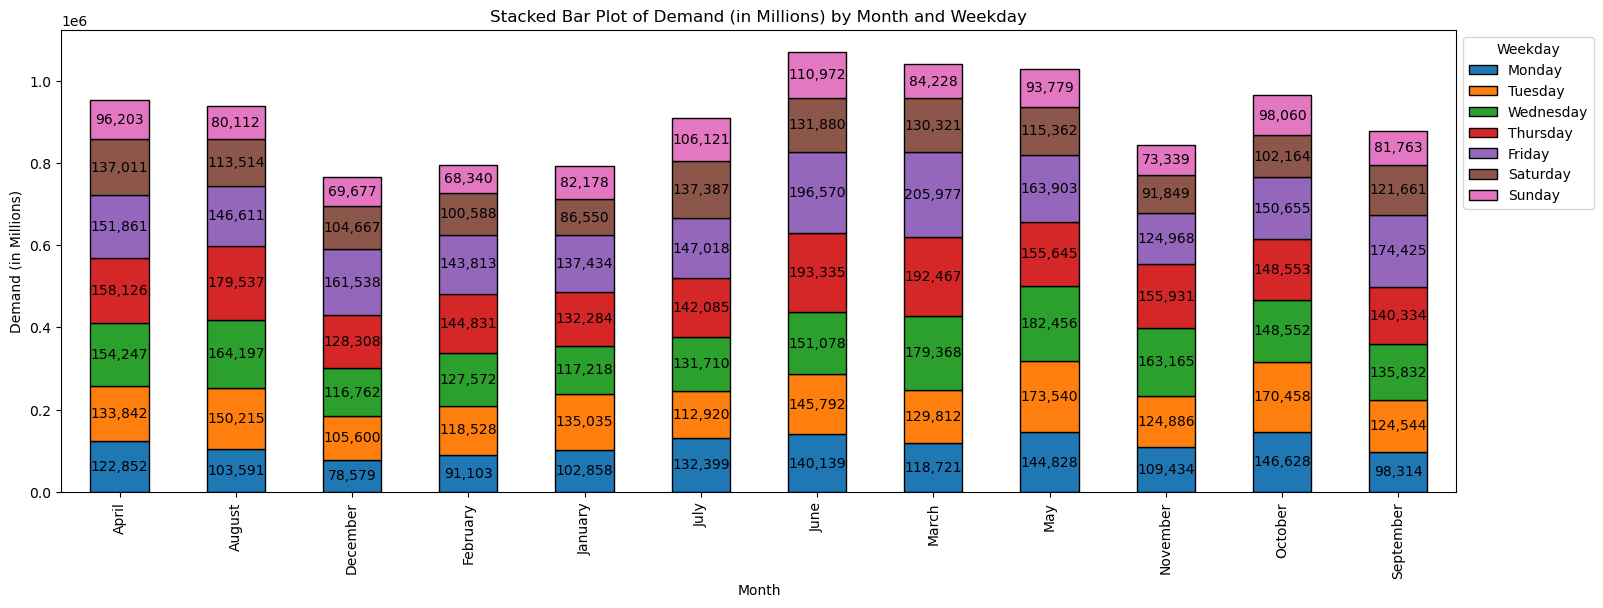

In [787]:
ax = pivot_month.plot(kind='bar', stacked=True, figsize=(18, 6))
for container in ax.containers:
    plt.setp(container, edgecolor='black')
    for rect in container.patches:
        width = rect.get_width()
        height = rect.get_height()
        x = rect.get_x()
        y = rect.get_y()
        ax.text(x + width / 2, y + height / 2, f'{int(height):,}', ha='center', va='center', color='black')

plt.xlabel('Month')
plt.ylabel('Demand (in Millions)')
plt.title('Stacked Bar Plot of Demand (in Millions) by Month and Weekday')
plt.legend(title='Weekday', bbox_to_anchor=(1, 1))

plt.show()

## 2.3 Hourly Demand Patterns

In [791]:
df.head()

#,trip_id,taxi_id,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_census_tract,dropoff_census_tract,pickup_community_area,dropoff_community_area,fare,tips,tolls,extras,trip_total,payment_type,company,pickup_centroid_latitude,pickup_centroid_longitude,dropoff_centroid_latitude,dropoff_centroid_longitude,trip_start_hour,trip_end_hour,trip_start_4h_period,trip_end_4h_period,trip_start_month,trip_start_day,trip_end_month,trip_start_date
0,1b545d0be27b195076e5d2a7d4fc0ebef6ef20ac,'56a1119c6ca57e39525cf06829f9ecff553cf4b5ac24821...,2017-01-01 00:00:00.000000,2017-01-01 00:00:00.000000,240,1.3,1.70318e+10,1.70318e+10,32,28,6.25,0,0,0,6.25,Cash,Taxi Affiliation Services,41.881,-87.6327,41.8853,-87.6572,0,0,0,0,1,1,1,2017-01-01
1,c3ee40051c5643c54064a8b9df3686d2d411518d,'7987cfe5e3b2c9869665f70fe35dbe7423e7fc5852f2d6f...,2017-01-01 00:00:00.000000,2017-01-01 00:15:00.000000,1500,0.4,1.70318e+10,1.70311e+10,32,8,22.75,4.85,0,1.5,29.1,Credit Card,Blue Ribbon Taxi Association Inc.,41.881,-87.6327,41.8983,-87.6208,0,0,0,0,1,1,1,2017-01-01
2,29f30c8a6bbc028f5d63aa18c708d31b47267a9f,'0b269137bd94b55212311226d9e1554423e12bcc16a432c...,2017-01-01 00:00:00.000000,2017-01-01 00:30:00.000000,1620,0.9,1.70318e+10,1.70311e+10,32,8,12.25,2.85,0,2,17.1,Credit Card,Taxi Affiliation Services,41.881,-87.6327,41.8925,-87.6262,0,0,0,0,1,1,1,2017-01-01
3,55ae4fa955e6bc8705b995248c34f4183d848c27,'d1d781b6807176ed53fbb9d0010dd0a87e29c073984bda6...,2017-01-01 00:00:00.000000,2017-01-01 00:00:00.000000,540,1,1.70311e+10,1.70311e+10,8,8,6.75,0,0,2,8.75,Cash,Dispatch Taxi Affiliation,41.9028,-87.6261,41.8909,-87.6189,0,0,0,0,1,1,1,2017-01-01
4,ce908cd441e28d08dfb22bf168102beabb5e16e4,'f7630edc68a131c4a97382dd93206949da80ec1443d8da7...,2017-01-01 00:00:00.000000,2017-01-01 00:15:00.000000,480,0.5,1.70311e+10,1.70311e+10,8,8,6.25,2,0,1.5,9.75,Credit Card,Taxi Affiliation Services,41.8925,-87.6262,41.8909,-87.6189,0,0,0,0,1,1,1,2017-01-01
5,fd25560e18dab95225999c264586a331dc3283f5,'9ff153898c75dbd960a207b660a71f92f79b666dcec98e1...,2017-01-01 00:00:00.000000,2017-01-01 00:30:00.000000,1980,3.4,1.70318e+10,1.70311e+10,32,8,16.75,3.65,0,1.5,21.9,Credit Card,Taxi Affiliation Services,41.881,-87.6327,41.895,-87.6197,0,0,0,0,1,1,1,2017-01-01
6,2504e0bf058ff310ac4c197618a843f88fc1c0c6,'d3a5f1452b4a1db2a547e7a0aabfe28d67c62b0e40155fa...,2017-01-01 00:00:00.000000,2017-01-01 00:15:00.000000,960,5.9,1.70313e+10,1.70311e+10,32,6,17.5,0,0,1,18.5,Cash,Northwest Management LLC,41.8774,-87.622,41.9427,-87.6518,0,0,0,0,1,1,1,2017-01-01
7,4ca1087133dfd8bde2483cb2aaa609fff2654f7c,'0083fcde0fb490b4ec424c63d1d750378f6ad11154d1d4a...,2017-01-01 00:00:00.000000,2017-01-01 00:15:00.000000,780,0.1,1.70312e+10,1.70311e+10,24,8,9.5,2.1,0,1,12.6,Credit Card,Taxi Affiliation Services,41.8997,-87.665,41.892,-87.6319,0,0,0,0,1,1,1,2017-01-01
8,04bc3089a41c33afc9b6cbf5a9beac4fed91da7c,'785ef52cff80fe78a7ee899453036c0be6ac8fef4d10068...,2017-01-01 00:00:00.000000,2017-01-01 00:00:00.000000,120,0.4,1.70318e+10,1.70318e+10,32,32,4.25,2,0,1,7.25,Credit Card,Chicago Medallion Leasing INC,41.881,-87.6327,41.881,-87.6327,0,0,0,0,1,1,1,2017-01-01
9,e09945909ae154d6b0ce433468baddcf79f79973,'b329626db30d23db0e6620de7d1a3036dd3c2ca3e139fd4...,2017-01-01 00:00:00.000000,2017-01-01 00:00:00.000000,180,0.7,1.70318e+10,1.70318e+10,32,28,5,0,0,2,7,Cash,Dispatch Taxi Affiliation,41.881,-87.6327,41.8853,-87.6572,0,0,0,0,1,1,1,2017-01-01


In [950]:
df_hourly = df[['trip_id','trip_start_date','trip_start_hour']]

In [951]:
df_hourly.head()

#,trip_id,trip_start_date,trip_start_hour
0,1b545d0be27b195076e5d2a7d4fc0ebef6ef20ac,2017-01-01,0
1,c3ee40051c5643c54064a8b9df3686d2d411518d,2017-01-01,0
2,29f30c8a6bbc028f5d63aa18c708d31b47267a9f,2017-01-01,0
3,55ae4fa955e6bc8705b995248c34f4183d848c27,2017-01-01,0
4,ce908cd441e28d08dfb22bf168102beabb5e16e4,2017-01-01,0
5,fd25560e18dab95225999c264586a331dc3283f5,2017-01-01,0
6,2504e0bf058ff310ac4c197618a843f88fc1c0c6,2017-01-01,0
7,4ca1087133dfd8bde2483cb2aaa609fff2654f7c,2017-01-01,0
8,04bc3089a41c33afc9b6cbf5a9beac4fed91da7c,2017-01-01,0
9,e09945909ae154d6b0ce433468baddcf79f79973,2017-01-01,0


In [952]:
count_hourly_total = df_hourly.groupby(by='trip_start_hour').agg({'count': vaex.agg.count('trip_id')}) 

In [953]:
count_hourly_total = count_hourly_total.to_pandas_df()
count_hourly_total['hour_format'] = count_hourly_total['trip_start_hour'].apply(lambda x: f'{x:02d}:00')

In [954]:
count_hourly_total.head()

,trip_start_hour,count,hour_format
0,0,245059,00:00
1,1,190119,01:00
2,2,139221,02:00
3,3,88317,03:00
4,4,46120,04:00


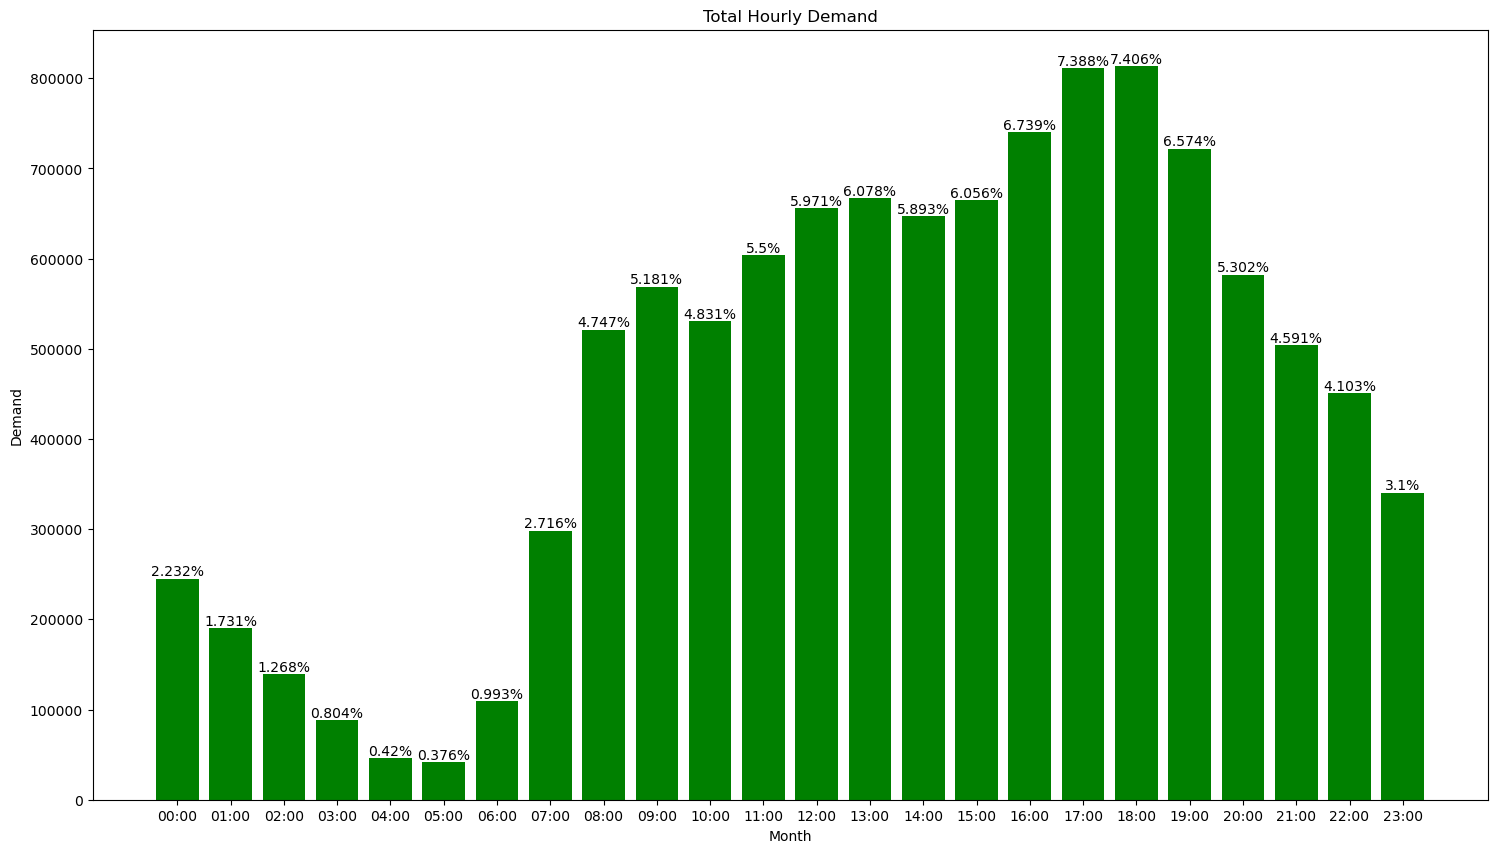

In [955]:
plt.figure(figsize=(18, 10))
bars = plt.bar(count_hourly_total['hour_format'], count_hourly_total['count'], color='green')
for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
             f"{round(bar.get_height() / total_demand * 100, 3)}%", ha='center', va='bottom', fontsize=10, color='black')

plt.xlabel('Month')
plt.ylabel('Demand')
plt.title('Total Hourly Demand')
plt.show()

## 2.3.1 Impact of Weekends on Hourly Demand

In [956]:
df_hourly['isWeekend'] = df_hourly['trip_start_date'].dt.dayofweek >= 5

In [957]:
df_hourly.head(25000)

#,trip_id,trip_start_date,trip_start_hour,isWeekend
0,1b545d0be27b195076e5d2a7d4fc0ebef6ef20ac,2017-01-01,0,True
1,c3ee40051c5643c54064a8b9df3686d2d411518d,2017-01-01,0,True
2,29f30c8a6bbc028f5d63aa18c708d31b47267a9f,2017-01-01,0,True
3,55ae4fa955e6bc8705b995248c34f4183d848c27,2017-01-01,0,True
4,ce908cd441e28d08dfb22bf168102beabb5e16e4,2017-01-01,0,True
...,...,...,...,...
"24,995",f66eed3ccf9b964e78fce2b73d30ebfc8d715a37,2017-01-02,15,False
"24,996",4167e31d45ce585d3120c68fcee505dfddf8e081,2017-01-02,15,False
"24,997",383ed930ddcf494d026cd1197579311d6ba3a3ab,2017-01-02,15,False
"24,998",4f0baab8d0e2bad125e3ff8cc517543241fbd724,2017-01-02,15,False


In [958]:
count_hourly_weekend = df_hourly.groupby(by=['trip_start_hour','isWeekend']).agg({'count': vaex.agg.count('trip_id')}) 

In [959]:
count_hourly_weekend = count_hourly_weekend.to_pandas_df()

In [960]:
count_hourly_weekend.head()

,trip_start_hour,isWeekend,count
0,0,False,92258
1,0,True,152801
2,1,False,45520
3,1,True,144599
4,2,False,20519


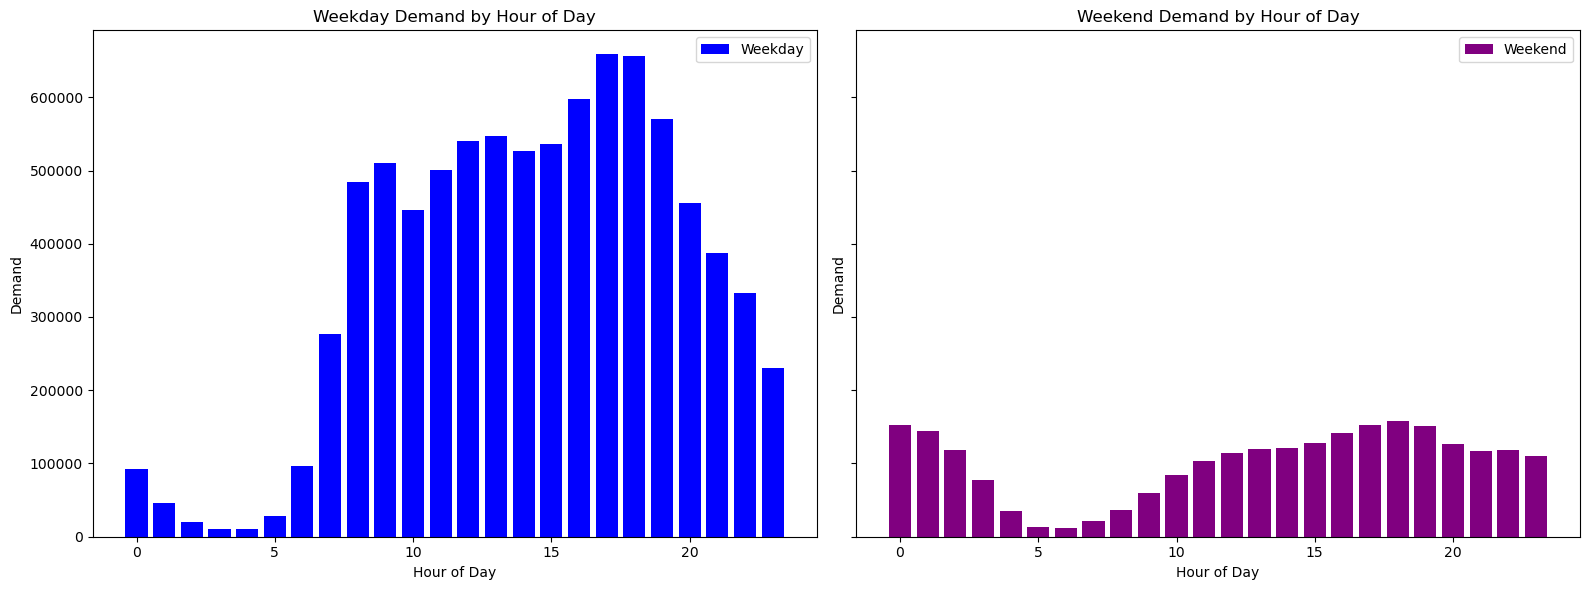

In [961]:
weekday_data = count_hourly_weekend[count_hourly_weekend['isWeekend'] == False]
weekend_data = count_hourly_weekend[count_hourly_weekend['isWeekend'] == True]

fig, axs = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
axs[0].bar(weekday_data['trip_start_hour'], weekday_data['count'], color='b', label='Weekday')
axs[0].set_title('Weekday Demand by Hour of Day')
axs[0].set_xlabel('Hour of Day')
axs[0].set_ylabel('Demand')
axs[0].legend()

axs[1].bar(weekend_data['trip_start_hour'], weekend_data['count'], color='purple', label='Weekend')
axs[1].set_title('Weekend Demand by Hour of Day')
axs[1].set_xlabel('Hour of Day')
axs[1].set_ylabel('Demand')
axs[1].legend()

plt.tight_layout()
plt.show()

## 2.3.2 Impact of Rushhour on hourly Demand

In [966]:
#Typical rushhour: 06:00-08:00 and 16:00-18:00
count_hourly_total['isRushhour'] = count_hourly_total['trip_start_hour'].apply(lambda x: True if (x >= 6 and x <= 8) or (x >= 16 and x <= 18) else False)

In [967]:
count_hourly_total.head()

,trip_start_hour,count,hour_format,isRushhour
0,0,245059,00:00,False
1,1,190119,01:00,False
2,2,139221,02:00,False
3,3,88317,03:00,False
4,4,46120,04:00,False


In [973]:
rushhour_demand = count_hourly_total.groupby('isRushhour')['count'].sum().reset_index()
total_demaand = count_hourly_total['count'].sum()

In [974]:
rushhour_demand.head()

,isRushhour,count
0,False,7687756
1,True,3292954


Rushhour includes all hours between 06:00 and 08:00, as well as 16:00 and 18:00. Thus rushhour spans over 6 hours daily, representing a proportion of 25% of a days time.
Non-rushhours are thus 18 hourse, representing 75% of a days time.

In [982]:
print('Percentage of Rushhour-Demand of Total Demand:', (rushhour_demand[rushhour_demand['isRushhour'] == True]['count'].sum()) / total_demand * 100, '%')
print('Percentage of non-Rushhour-Demand of Total Demand:', (rushhour_demand[rushhour_demand['isRushhour'] == False]['count'].sum()) / total_demand * 100, '%')

Percentage of Rushhour-Demand of Total Demand: 29.988534439029902 %
Percentage of non-Rushhour-Demand of Total Demand: 70.0114655609701 %


In [983]:
correlation = count_hourly_total['isRushhour'].corr(trip_counts_date['count'])
print(f"Correlation between the Rushhour and demand: {correlation:.2f}")

Correlation between the Rushhour and demand: 0.04


## 2.3.3 Impact of Temperature on hourly Demand

In [846]:
weather_df.head()

,date,time,temp,precip,condition,date_time
0,2017-01-01,00:53,33 °F,0.0 °in,Partly Cloudy,2017-01-01 00:53:00
1,2017-01-01,01:53,25 °F,0.0 °in,Fair,2017-01-01 01:53:00
2,2017-01-01,02:53,25 °F,0.0 °in,Fair,2017-01-01 02:53:00
3,2017-01-01,03:53,25 °F,0.0 °in,Fair,2017-01-01 03:53:00
4,2017-01-01,04:53,24 °F,0.0 °in,Fair,2017-01-01 04:53:00


In [892]:
#copy weather_df
hourly_weather = weather_df.copy()

#bring time into hourly format to enable merge with hourly demand dataframe
hourly_weather['hourly_time'] = pd.to_datetime(hourly_weather['date_time']).dt.strftime('%H:00')
hourly_weather.drop(['time', 'date_time'], axis=1)

#Remove units of precip and temp to enable calculations - same as above
hourly_weather = hourly_weather.copy()
hourly_weather['temp'] = hourly_weather.loc[:, 'temp'].astype(str)
hourly_weather.loc[:,'temp'] = hourly_weather['temp'].astype(str).str.strip(' °F').astype(float)

hourly_weather['precip'] = hourly_weather['precip'].astype(str).str.strip(' °in').astype(float)
hourly_weather['date'] = pd.to_datetime(hourly_weather['date'])

#Map weather conditions same way it was done earlier
hourly_weather['condition_map'] = hourly_weather['condition'].map(conditions_map)
hourly_weather['condition_map'] = hourly_weather['condition_map'].astype(float)

#Mapping seasons for every date

In [893]:
hourly_weather.head(50)

,date,time,temp,precip,condition,date_time,hourly_time,condition_map
0,2017-01-01,00:53,33.0,0.0,Partly Cloudy,2017-01-01 00:53:00,00:00,2.0
1,2017-01-01,01:53,25.0,0.0,Fair,2017-01-01 01:53:00,01:00,0.0
2,2017-01-01,02:53,25.0,0.0,Fair,2017-01-01 02:53:00,02:00,0.0
3,2017-01-01,03:53,25.0,0.0,Fair,2017-01-01 03:53:00,03:00,0.0
4,2017-01-01,04:53,24.0,0.0,Fair,2017-01-01 04:53:00,04:00,0.0
5,2017-01-01,05:53,22.0,0.0,Fair,2017-01-01 05:53:00,05:00,0.0
6,2017-01-01,06:53,22.0,0.0,Cloudy,2017-01-01 06:53:00,06:00,3.0
7,2017-01-01,07:53,22.0,0.0,Cloudy,2017-01-01 07:53:00,07:00,3.0
8,2017-01-01,08:53,22.0,0.0,Cloudy,2017-01-01 08:53:00,08:00,3.0
9,2017-01-01,09:53,26.0,0.0,Fair,2017-01-01 09:53:00,09:00,0.0


In [886]:
# aggregate mean temperature of whole year on hourly basis
mean_temp_hourly = hourly_weather.groupby(['hourly_time'])['temp'].mean().reset_index()

In [887]:
mean_temp_hourly.head()

,hourly_time,temp
0,00:00,50.997260
1,01:00,50.501370
2,02:00,49.868493
3,03:00,49.323288
4,04:00,48.791781


/var/folders/hq/f9hjcnyx11b9j8sjwvfmz1lc0000gn/T/ipykernel_3753/783515327.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(count_hourly_total['hour_format'], rotation=45)


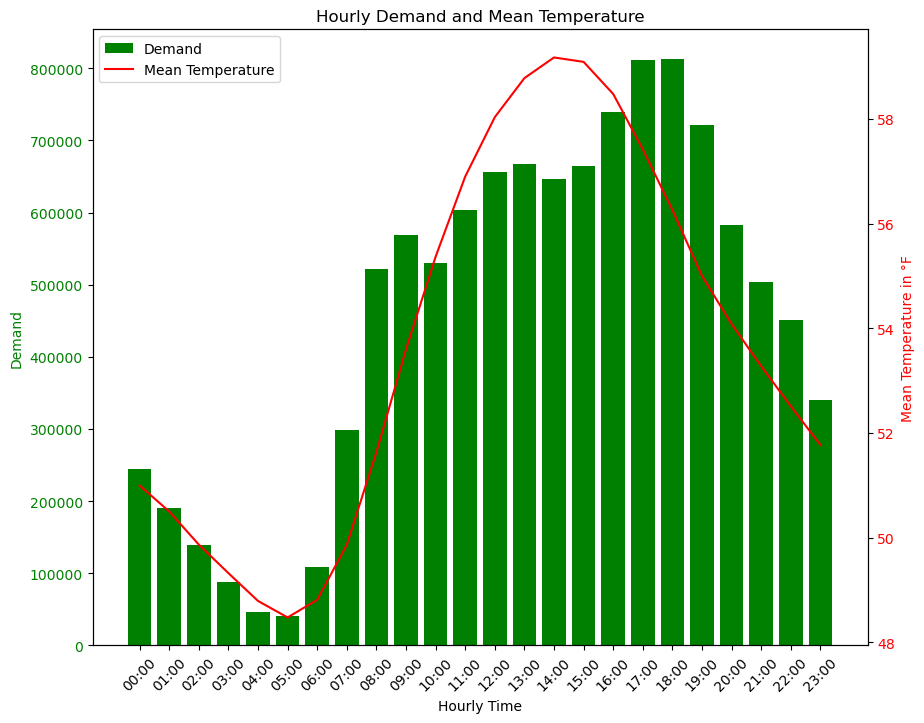

In [1089]:
fig, ax1 = plt.subplots(figsize=(10, 8))

ax1.bar(count_hourly_total['hour_format'], count_hourly_total['count'], color='green', label='Demand')
ax1.set_xlabel('Hourly Time')
ax1.set_ylabel('Demand', color='green')
ax1.tick_params(axis='y', labelcolor='green')

ax2 = ax1.twinx()

ax2.plot(mean_temp_hourly['hourly_time'], mean_temp_hourly['temp'], color='r', label='Mean Temperature')
ax2.set_ylabel('Mean Temperature in °F', color='r')
ax2.tick_params(axis='y', labelcolor='r')
ax1.set_xticklabels(count_hourly_total['hour_format'], rotation=45)

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

plt.xticks(rotation=70)
plt.title('Hourly Demand and Mean Temperature')
plt.show()

In [889]:
correlation = mean_temp_hourly['temp'].corr(count_hourly_total['count'])
print(f"Correlation between the hourly temperature and hourly demand: {correlation:.2f}")

Correlation between the hourly temperature and hourly demand: 0.91


## 2.3.4 Impact of Precip on Hourly Demand

In [878]:
mean_precip_hourly = hourly_weather.groupby(['hourly_time'])['precip'].mean().reset_index()

/var/folders/hq/f9hjcnyx11b9j8sjwvfmz1lc0000gn/T/ipykernel_3753/881568530.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(count_hourly_total['hour_format'], rotation=45)


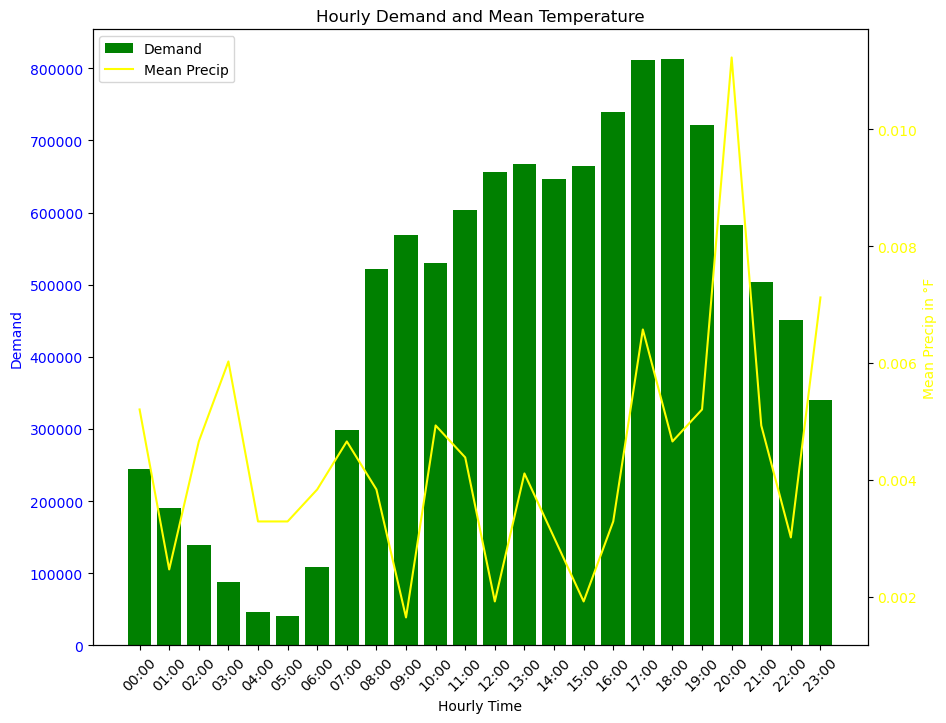

In [884]:
fig, ax1 = plt.subplots(figsize=(10, 8))

ax1.bar(count_hourly_total['hour_format'], count_hourly_total['count'], color='green', label='Demand')
ax1.set_xlabel('Hourly Time')
ax1.set_ylabel('Demand', color='b')
ax1.tick_params(axis='y', labelcolor='b')

ax2 = ax1.twinx()

ax2.plot(mean_precip_hourly['hourly_time'], mean_precip_hourly['precip'], color='yellow', label='Mean Precip')
ax2.set_ylabel('Mean Precip in °F', color='yellow')
ax2.tick_params(axis='y', labelcolor='yellow')
ax1.set_xticklabels(count_hourly_total['hour_format'], rotation=45)

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

plt.xticks(rotation=70)
plt.title('Hourly Demand and Mean Precipitation')
plt.show()

In [890]:
correlation = mean_precip_hourly['precip'].corr(count_hourly_total['count'])
print(f"Correlation between the hourly temperature and hourly demand: {correlation:.2f}")

Correlation between the hourly temperature and hourly demand: 0.04


## 2.3.5 Impact of weather conditions on hourly Demand

In [904]:
# Here now rounding, as differences would be non existent
mean_condition_hourly = hourly_weather.groupby(['hourly_time'])['condition_map'].mean().reset_index()

In [905]:
mean_condition_hourly.head()

,hourly_time,condition_map
0,00:00,1.746951
1,01:00,1.715596
2,02:00,1.660494
3,03:00,1.648148
4,04:00,1.673981


/var/folders/hq/f9hjcnyx11b9j8sjwvfmz1lc0000gn/T/ipykernel_3753/1512121713.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(count_hourly_total['hour_format'], rotation=45)


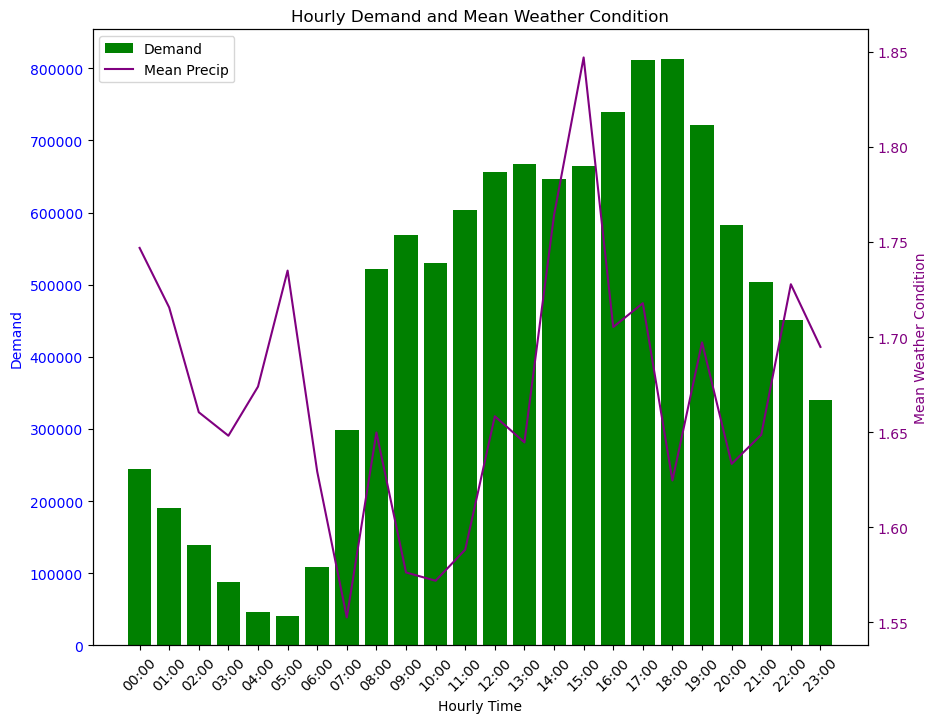

In [907]:
fig, ax1 = plt.subplots(figsize=(10, 8))

ax1.bar(count_hourly_total['hour_format'], count_hourly_total['count'], color='green', label='Demand')
ax1.set_xlabel('Hourly Time')
ax1.set_ylabel('Demand', color='b')
ax1.tick_params(axis='y', labelcolor='b')

ax2 = ax1.twinx()

ax2.plot(mean_condition_hourly['hourly_time'], mean_condition_hourly['condition_map'], color='purple', label='Mean Precip')
ax2.set_ylabel('Mean Weather Condition', color='purple')
ax2.tick_params(axis='y', labelcolor='purple')

ax1.set_xticklabels(count_hourly_total['hour_format'], rotation=45)

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

plt.xticks(rotation=70)
plt.title('Hourly Demand and Mean Weather Condition')
plt.show()

In [908]:
correlation = mean_condition_hourly['condition_map'].corr(count_hourly_total['count'])
print(f"Correlation between the hourly temperature and hourly demand: {correlation:.2f}")

Correlation between the hourly temperature and hourly demand: 0.03


## 2.3.6 Impact of seasons on hourly Demand

In [986]:
#again mapping months to season, just like before
df_hourly['season'] = df_hourly['trip_start_date'].dt.month.map(seasons_map)

In [987]:
df_hourly.head()

#,trip_id,trip_start_date,trip_start_hour,isWeekend,season
0,1b545d0be27b195076e5d2a7d4fc0ebef6ef20ac,2017-01-01,0,True,Winter
1,c3ee40051c5643c54064a8b9df3686d2d411518d,2017-01-01,0,True,Winter
2,29f30c8a6bbc028f5d63aa18c708d31b47267a9f,2017-01-01,0,True,Winter
3,55ae4fa955e6bc8705b995248c34f4183d848c27,2017-01-01,0,True,Winter
4,ce908cd441e28d08dfb22bf168102beabb5e16e4,2017-01-01,0,True,Winter
5,fd25560e18dab95225999c264586a331dc3283f5,2017-01-01,0,True,Winter
6,2504e0bf058ff310ac4c197618a843f88fc1c0c6,2017-01-01,0,True,Winter
7,4ca1087133dfd8bde2483cb2aaa609fff2654f7c,2017-01-01,0,True,Winter
8,04bc3089a41c33afc9b6cbf5a9beac4fed91da7c,2017-01-01,0,True,Winter
9,e09945909ae154d6b0ce433468baddcf79f79973,2017-01-01,0,True,Winter


In [994]:
count_hourly_season = df_hourly.groupby(by=['trip_start_hour','season']).agg({'count': vaex.agg.count('trip_id')}) 

In [996]:
count_hourly_season = count_hourly_season.to_pandas_df()
count_hourly_season.head()

,trip_start_hour,season,count
0,0,Winter,49652
1,0,Summer,76817
2,0,Fall,53572
3,0,Spring,65018
4,1,Winter,42735


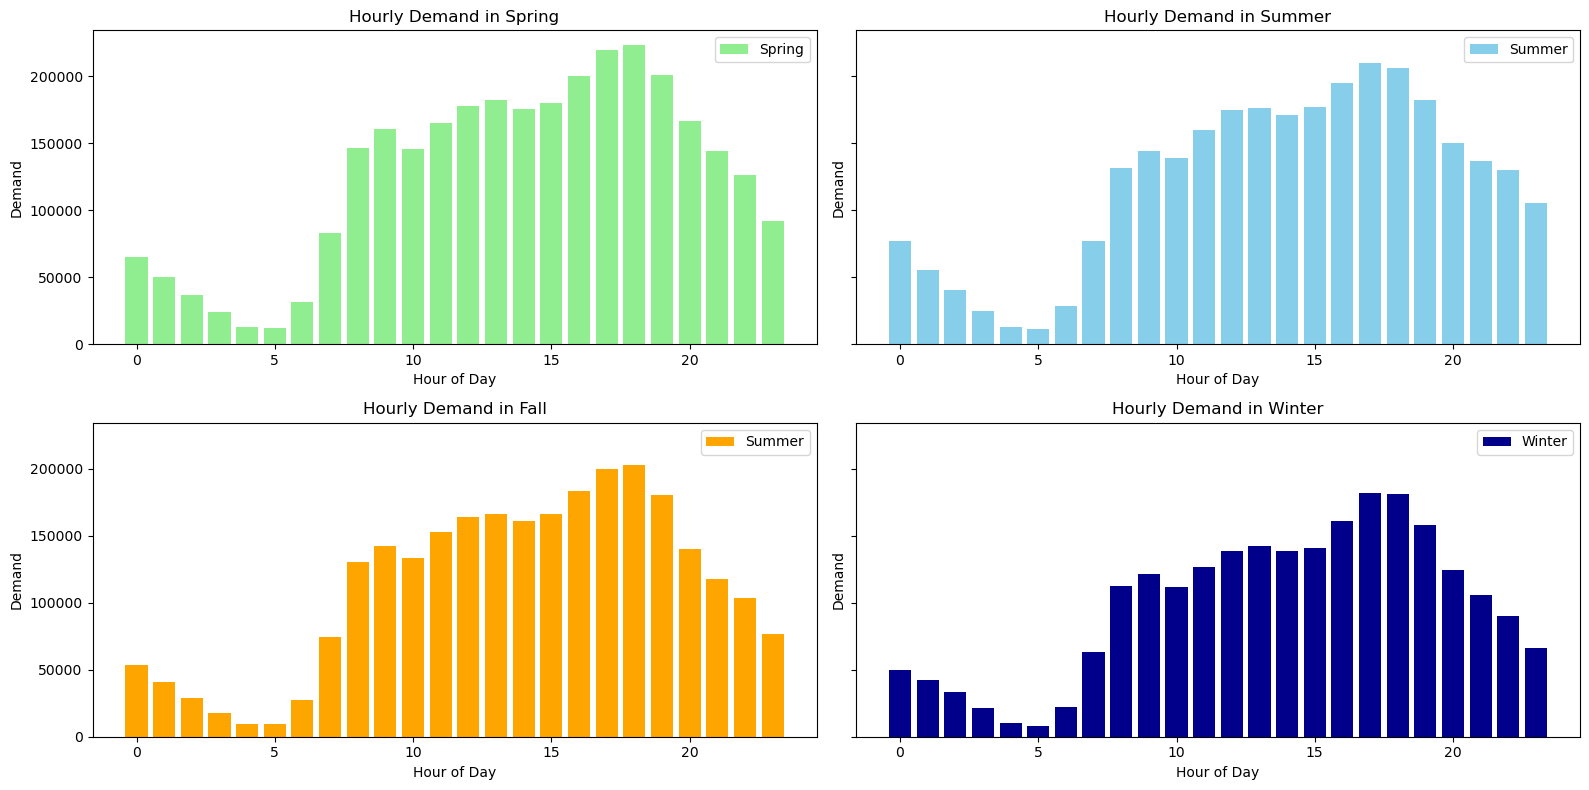

In [1003]:
#similar to weekday/weekend data, create individual dataframes for each season (winter,spring,summer,fall)
spring_data = count_hourly_season[count_hourly_season['season'] == 'Spring']
summer_data = count_hourly_season[count_hourly_season['season'] == 'Summer']
fall_data = count_hourly_season[count_hourly_season['season'] == 'Fall']
winter_data = count_hourly_season[count_hourly_season['season'] == 'Winter']

fig, axs = plt.subplots(2,2, figsize=(16, 8), sharey=True)
axs[0, 0].bar(spring_data['trip_start_hour'], spring_data['count'], color='lightgreen', label='Spring')
axs[0, 0].set_title('Hourly Demand in Spring')
axs[0, 0].set_xlabel('Hour of Day')
axs[0, 0].set_ylabel('Demand')
axs[0, 0].legend()

axs[0, 1].bar(summer_data['trip_start_hour'], summer_data['count'], color='skyblue', label='Summer')
axs[0, 1].set_title('Hourly Demand in Summer')
axs[0, 1].set_xlabel('Hour of Day')
axs[0, 1].set_ylabel('Demand')
axs[0, 1].legend()

axs[1, 0].bar(fall_data['trip_start_hour'], fall_data['count'], color='orange', label='Summer')
axs[1, 0].set_title('Hourly Demand in Fall')
axs[1, 0].set_xlabel('Hour of Day')
axs[1, 0].set_ylabel('Demand')
axs[1, 0].legend()

axs[1, 1].bar(winter_data['trip_start_hour'], winter_data['count'], color='darkblue', label='Winter')
axs[1, 1].set_title('Hourly Demand in Winter')
axs[1, 1].set_xlabel('Hour of Day')
axs[1, 1].set_ylabel('Demand')
axs[1, 1].legend()

plt.tight_layout()
plt.show()

## 2.4 Changes in Fares, Tolls, Extras in comparison to demand changes

## 2.4.1 Changes of financial metrics in comparison to yearly demand

In [1005]:
trip_counts_date.head()

,trip_start_date,count,isHoliday,isWeekend,weekday,season,weekday_name,month,month_name
0,2017-01-01,19944,True,True,6,Winter,Sunday,1,January
1,2017-01-02,9697,True,False,0,Winter,Monday,1,January
2,2017-01-03,19541,False,False,1,Winter,Tuesday,1,January
3,2017-01-04,25692,False,False,2,Winter,Wednesday,1,January
4,2017-01-05,32098,False,False,3,Winter,Thursday,1,January


In [1039]:
sum_fares= df.groupby(by='trip_start_date').agg({'sum_fare': vaex.agg.sum('fare')})

In [1040]:
sum_tips = df.groupby(by='trip_start_date').agg({'sum_tips': vaex.agg.sum('tips')})

In [1041]:
sum_tolls = df.groupby(by='trip_start_date').agg({'sum_tolls': vaex.agg.sum('tolls')})

In [1042]:
sum_extras = df.groupby(by='trip_start_date').agg({'sum_extras': vaex.agg.sum('extras')})

In [1043]:
sum_totals = df.groupby(by='trip_start_date').agg({'sum_totals': vaex.agg.sum('trip_total')})

In [1037]:
sum_totals.head()

#,trip_start_date,sum_totals
0,2017-09-23,366729
1,2017-01-18,419520
2,2017-08-14,438961
3,2017-02-20,297062
4,2017-03-26,399575
5,2017-09-13,673447
6,2017-11-01,568534
7,2017-04-13,578236
8,2017-05-11,648349
9,2017-09-06,451541


In [1058]:
#sum_fares = sum_fares.to_pandas_df()
sum_fares = sum_fares.sort_values(by=['trip_start_date'])

sum_tips = sum_tips.to_pandas_df()
sum_tips = sum_tips.sort_values(by=['trip_start_date'])

sum_tolls = sum_tolls.to_pandas_df()
sum_tolls = sum_tolls.sort_values(by=['trip_start_date'])

sum_extras = sum_extras.to_pandas_df()
sum_extras = sum_extras.sort_values(by=['trip_start_date'])

sum_totals = sum_totals.to_pandas_df()
sum_totals = sum_totals.sort_values(by=['trip_start_date'])

AttributeError: 'DataFrame' object has no attribute 'to_pandas_df'

In [ ]:
sum_finance = pd.merge(sum_fares, sum_tips, on='trip_start_date', how='outer')
sum_finance = pd.merge(sum_finance, sum_tolls, on='trip_start_date', how='outer')
sum_finance = pd.merge(sum_finance, sum_extras, on='trip_start_date', how='outer')
sum_finance = pd.merge(sum_finance, sum_totals, on='trip_start_date', how='outer')

In [1059]:
sum_finance = sum_finance.sort_values(by=['trip_start_date'])
sum_finance.head()

,trip_start_date,sum_fare,sum_tips,sum_tolls,sum_extras,sum_totals
243,2017-01-01,231135.15,23149.96,0.0,21006.88,277753.49
11,2017-01-02,137955.75,14829.08,5.0,11821.54,165907.37
73,2017-01-03,233159.77,26754.62,0.0,12767.42,275477.81
194,2017-01-04,279242.07,34308.10,0.0,14872.91,332238.08
257,2017-01-05,393121.69,50130.70,4.0,21849.35,470215.36


We now four plots that track the development of fares, tolls, extras and totals in comparison to the demand. Here we always create two subplots (ax1 and ax2) since we need to different scales for demand and the metric. If we would not do that the metric's plot would not be visible due to its comparetively low values in comparison to the demand valeus.
The do subplots help us create fitting scales.

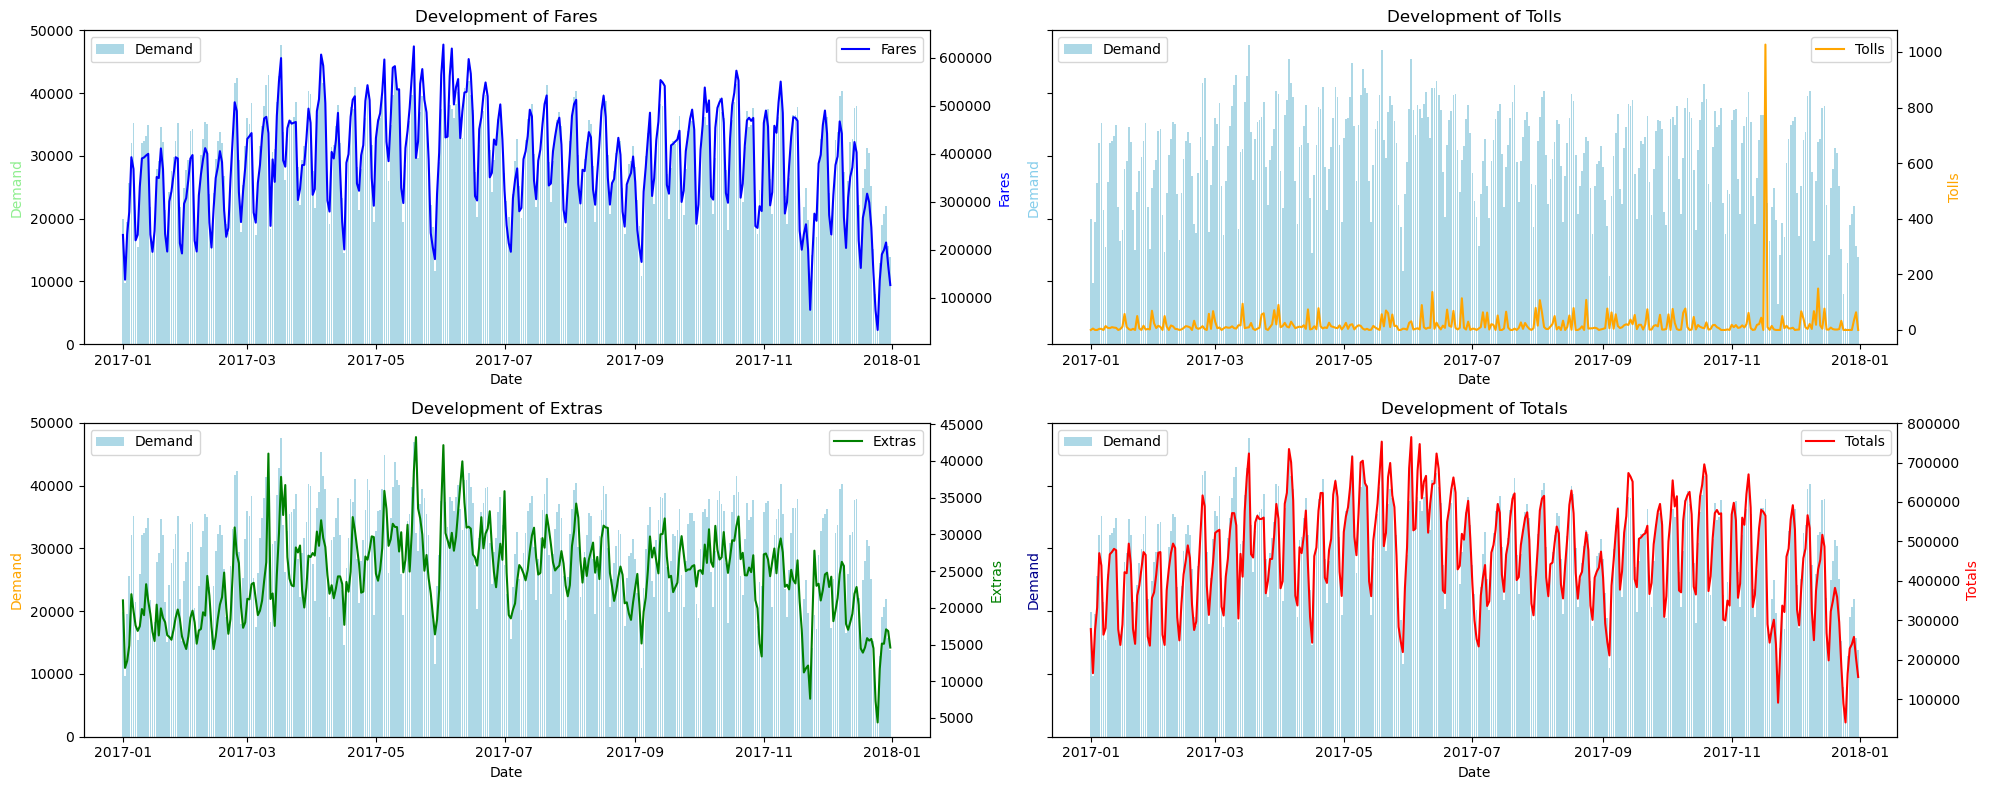

In [1069]:
#We now four plots that track the development of fares, tolls, extras and totals in comparison to the demand
#Here we always create two subplots (ax1 and ax2) since we need to different scales for demand and the metric
#If we would not do that the metric's plot would not be visible due to its comparetively low values in comparison to the demand valeus
#The do subplots help us create fitting scales

fig, axs = plt.subplots(2, 2, figsize=(20, 8), sharey=True)

# Plot for Fares
ax1 = axs[0, 0]
ax2 = ax1.twinx()
ax1.bar(trip_counts_date['trip_start_date'], trip_counts_date['count'], color='lightblue', label='Demand')
ax2.plot(sum_finance['trip_start_date'], sum_finance['sum_fare'], color='blue', label='Fares')
ax1.set_title('Development of Fares')
ax1.set_xlabel('Date')
ax1.set_ylabel('Demand', color='lightgreen')
ax2.set_ylabel('Fares', color='blue')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Plot for Tolls
ax1 = axs[0, 1]
ax2 = ax1.twinx()
ax1.bar(trip_counts_date['trip_start_date'], trip_counts_date['count'], color='lightblue', label='Demand')
ax2.plot(sum_finance['trip_start_date'], sum_finance['sum_tolls'], color='orange', label='Tolls')
ax1.set_title('Development of Tolls')
ax1.set_xlabel('Date')
ax1.set_ylabel('Demand', color='skyblue')
ax2.set_ylabel('Tolls', color='orange')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Plot for Extras
ax1 = axs[1, 0]
ax2 = ax1.twinx()
ax1.bar(trip_counts_date['trip_start_date'], trip_counts_date['count'], color='lightblue', label='Demand')
ax2.plot(sum_finance['trip_start_date'], sum_finance['sum_extras'], color='green', label='Extras')
ax1.set_title('Development of Extras')
ax1.set_xlabel('Date')
ax1.set_ylabel('Demand', color='orange')
ax2.set_ylabel('Extras', color='green')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Plot for Totals
ax1 = axs[1, 1]
ax2 = ax1.twinx()
ax1.bar(trip_counts_date['trip_start_date'], trip_counts_date['count'], color='lightblue', label='Demand')
ax2.plot(sum_finance['trip_start_date'], sum_finance['sum_totals'], color='red', label='Totals')
ax1.set_title('Development of Totals')
ax1.set_xlabel('Date')
ax1.set_ylabel('Demand', color='darkblue')
ax2.set_ylabel('Totals', color='red')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

In [1084]:
#copying trip_counts_date, drop all for this operation unnessecary columns
demand_df_slim = trip_counts_date[['trip_start_date', 'count']].copy()
#merge trip_counts_date (demand df) and sum_finance (metrics df) 
df_corr_demand_metrics = pd.merge(demand_df_slim, sum_finance, on='trip_start_date', how='outer')

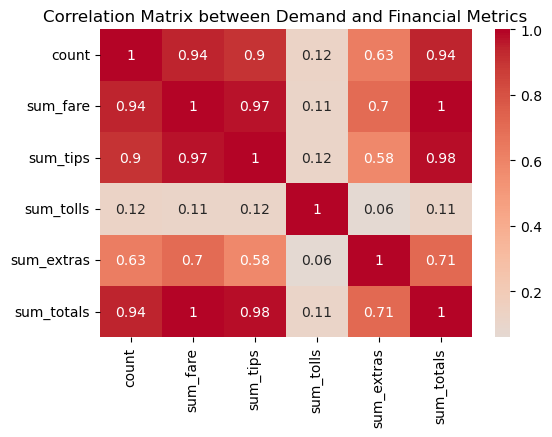

In [1086]:
#calculate correlation matrix
corr_matrix = df_corr_demand_metrics.corr()
#visualize correlation matrix
plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix between Demand and Financial Metrics')
plt.show()

As expected, the only low-correlation metric is tolls.

## 2.4.2 Changes of financial metrics in comparison to hourly demand

In [1091]:
df_hourly_fin = df[['trip_id','trip_start_date','trip_start_hour','fare','tips','tolls','extras','trip_total']]

In [1093]:
df_hourly_fin.head()

#,trip_id,trip_start_date,trip_start_hour,fare,tips,tolls,extras,trip_total
0,1b545d0be27b195076e5d2a7d4fc0ebef6ef20ac,2017-01-01,0,6.25,0,0,0,6.25
1,c3ee40051c5643c54064a8b9df3686d2d411518d,2017-01-01,0,22.75,4.85,0,1.5,29.1
2,29f30c8a6bbc028f5d63aa18c708d31b47267a9f,2017-01-01,0,12.25,2.85,0,2,17.1
3,55ae4fa955e6bc8705b995248c34f4183d848c27,2017-01-01,0,6.75,0,0,2,8.75
4,ce908cd441e28d08dfb22bf168102beabb5e16e4,2017-01-01,0,6.25,2,0,1.5,9.75
5,fd25560e18dab95225999c264586a331dc3283f5,2017-01-01,0,16.75,3.65,0,1.5,21.9
6,2504e0bf058ff310ac4c197618a843f88fc1c0c6,2017-01-01,0,17.5,0,0,1,18.5
7,4ca1087133dfd8bde2483cb2aaa609fff2654f7c,2017-01-01,0,9.5,2.1,0,1,12.6
8,04bc3089a41c33afc9b6cbf5a9beac4fed91da7c,2017-01-01,0,4.25,2,0,1,7.25
9,e09945909ae154d6b0ce433468baddcf79f79973,2017-01-01,0,5,0,0,2,7


In [1108]:
sum_fares_hour= df.groupby(by='trip_start_hour').agg({'sum_fare': vaex.agg.sum('fare')})

In [1109]:
sum_tips_hour= df.groupby(by='trip_start_hour').agg({'sum_tips': vaex.agg.sum('tips')})

In [1110]:
sum_tolls_hour= df.groupby(by='trip_start_hour').agg({'sum_tolls': vaex.agg.sum('tolls')})

In [1111]:
sum_extras_hour= df.groupby(by='trip_start_hour').agg({'sum_extras': vaex.agg.sum('extras')})

In [1112]:
sum_totals_hour= df.groupby(by='trip_start_hour').agg({'sum_total': vaex.agg.sum('trip_total')})

In [1113]:
sum_fares_hour = sum_fares_hour.to_pandas_df()
sum_fares_hour = sum_fares_hour.sort_values(by=['trip_start_hour'])

sum_tips_hour = sum_tips_hour.to_pandas_df()
sum_tips_hour = sum_tips_hour.sort_values(by=['trip_start_hour'])

sum_tolls_hour = sum_tolls_hour.to_pandas_df()
sum_tolls_hour = sum_tolls_hour.sort_values(by=['trip_start_hour'])

sum_extras_hour = sum_extras_hour.to_pandas_df()
sum_extras_hour = sum_extras_hour.sort_values(by=['trip_start_hour'])

sum_totals_hour = sum_totals_hour.to_pandas_df()
sum_totals_hour = sum_totals_hour.sort_values(by=['trip_start_hour'])

In [1115]:
sum_finance_hour = pd.merge(sum_fares_hour, sum_tips_hour, on='trip_start_hour', how='outer')
sum_finance_hour = pd.merge(sum_finance_hour, sum_tolls_hour, on='trip_start_hour', how='outer')
sum_finance_hour = pd.merge(sum_finance_hour, sum_extras_hour, on='trip_start_hour', how='outer')
sum_finance_hour = pd.merge(sum_finance_hour, sum_totals_hour, on='trip_start_hour', how='outer')

In [1116]:
sum_finance_hour.head()

,trip_start_hour,sum_fare,sum_tips,sum_tolls,sum_extras,sum_total
0,0,2670198.59,346155.96,61.00,245198.22,3297615.27
1,1,1864060.21,245988.52,205.00,180755.72,2321551.67
2,2,1262983.32,169162.66,84.55,123221.89,1577252.27
3,3,842617.33,109884.04,43.20,81284.84,1046152.62
4,4,683029.35,86355.44,36.04,41573.40,817741.13


In [1118]:
count_hourly_slim = count_hourly_total[['trip_start_hour','count']].copy()

In [1119]:
count_hourly_slim.head()

,trip_start_hour,count
0,0,245059
1,1,190119
2,2,139221
3,3,88317
4,4,46120


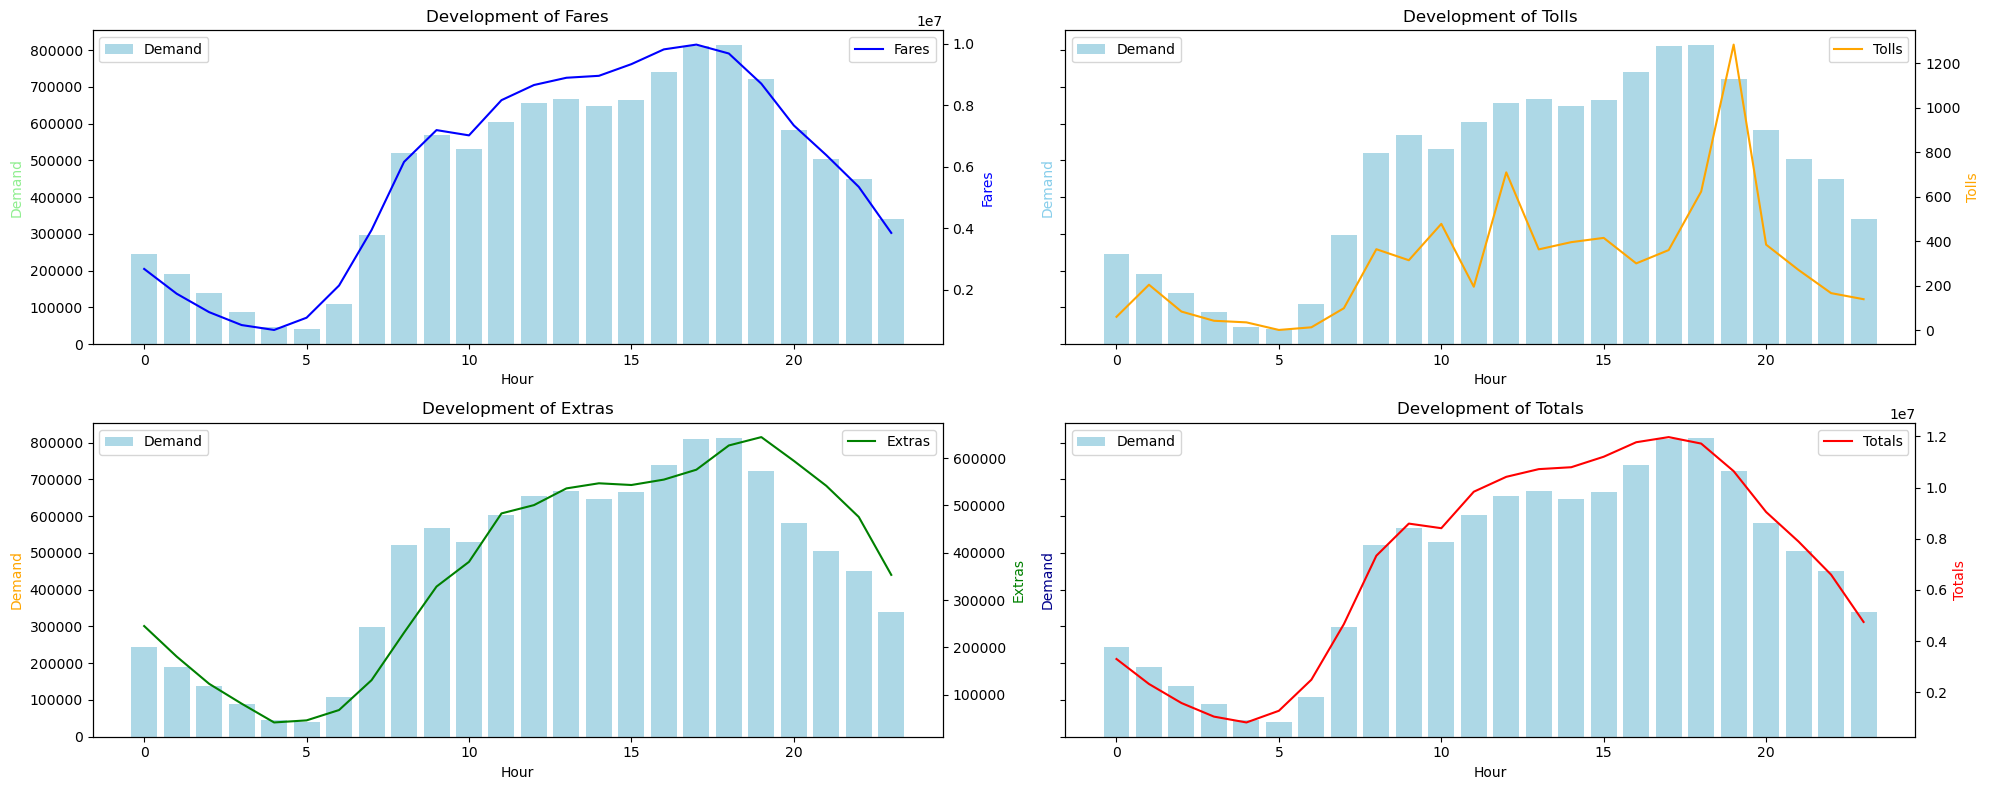

In [1123]:
fig, axs = plt.subplots(2, 2, figsize=(20, 8), sharey=True)

# Plot for Fares
ax1 = axs[0, 0]
ax2 = ax1.twinx()
ax1.bar(count_hourly_slim['trip_start_hour'], count_hourly_slim['count'], color='lightblue', label='Demand')
ax2.plot(sum_finance_hour['trip_start_hour'], sum_finance_hour['sum_fare'], color='blue', label='Fares')
ax1.set_title('Development of Fares')
ax1.set_xlabel('Hour')
ax1.set_ylabel('Demand', color='lightgreen')
ax2.set_ylabel('Fares', color='blue')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Plot for Tolls
ax1 = axs[0, 1]
ax2 = ax1.twinx()
ax1.bar(count_hourly_slim['trip_start_hour'], count_hourly_slim['count'], color='lightblue', label='Demand')
ax2.plot(sum_finance_hour['trip_start_hour'], sum_finance_hour['sum_tolls'], color='orange', label='Tolls')
ax1.set_title('Development of Tolls')
ax1.set_xlabel('Hour')
ax1.set_ylabel('Demand', color='skyblue')
ax2.set_ylabel('Tolls', color='orange')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Plot for Extras
ax1 = axs[1, 0]
ax2 = ax1.twinx()
ax1.bar(count_hourly_slim['trip_start_hour'], count_hourly_slim['count'], color='lightblue', label='Demand')
ax2.plot(sum_finance_hour['trip_start_hour'], sum_finance_hour['sum_extras'], color='green', label='Extras')
ax1.set_title('Development of Extras')
ax1.set_xlabel('Hour')
ax1.set_ylabel('Demand', color='orange')
ax2.set_ylabel('Extras', color='green')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Plot for Totals
ax1 = axs[1, 1]
ax2 = ax1.twinx()
ax1.bar(count_hourly_slim['trip_start_hour'], count_hourly_slim['count'], color='lightblue', label='Demand')
ax2.plot(sum_finance_hour['trip_start_hour'], sum_finance_hour['sum_total'], color='red', label='Totals')
ax1.set_title('Development of Totals')
ax1.set_xlabel('Hour')
ax1.set_ylabel('Demand', color='darkblue')
ax2.set_ylabel('Totals', color='red')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

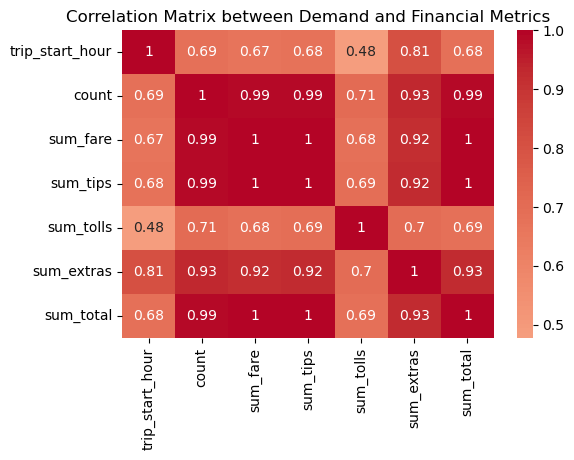

In [1124]:
df_corr_hour = pd.merge(count_hourly_slim, sum_finance_hour, on='trip_start_hour', how='outer')
corr_matrix_hour = df_corr_hour.corr()

plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix_hour, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix between Demand and Financial Metrics')
plt.show()

Same as with yearly demand: Demand and Metrics heavily correlated, even tolls have strong correlation